# Career-con-2019 Kaggle Competition

Website of the competition: https://www.kaggle.com/c/career-con-2019

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.signal 
%matplotlib inline
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

def load_data(filename):
    return pd.read_csv('./' + filename)

X_train = load_data("X_train.csv")
y_train = load_data("y_train.csv")
X_test = load_data("X_test.csv")

print("Training set data shape: ", X_train.shape)
print("Training set label shape:", y_train.shape)
print("Test set data shape:     ", X_test.shape)

Training set data shape:  (487680, 13)
Training set label shape: (3810, 3)
Test set data shape:      (488448, 13)


***

## Overview

In this Kaggle competition participants should determine the floor surface an unknown robot is standing on, based on data collected by various Inertial Measurement Units (IMU) sensors. 

There are 9 possible **surfaces**: carpet, concrete, fine concrete, hard tiles, hard tiles large space, soft pvc, soft tiles, tiled, wood

The IMU sensors collected 10 different types of data (**channels**):

* **Linear acceleration** along the three axis (3 channels X, Y, Z)


* **Angular velocity** around the three axis (3 channels X, Y, Z)


* **Angular orientation** in quaternionic representation (4 channels X, Y, Z, W)

The training set $X_{\text{train}}$, given as a matrix of dimension (3810 $\times$ 128, 13), consists of 3810 different time series observations, each with 128 measurements; the columns in the matrix represent the data for the 10 channels together with the **time series id** (from 0 to 3809), the **measurement number** (from 0 to 127 for each time series) and the **row id** given as combination of time series id and measurement number:

In [2]:
print("Dimension of X_train: {}; number of train time series: {}/128 = {}".format(X_train.shape, 
        X_train.shape[0], X_train.shape[0]//128))
print()
X_train.head()

Dimension of X_train: (487680, 13); number of train time series: 487680/128 = 3810



row_id  series_id  measurement_number  orientation_X  orientation_Y  \
0    0_0          0                   0       -0.75853       -0.63435   
1    0_1          0                   1       -0.75853       -0.63434   
2    0_2          0                   2       -0.75853       -0.63435   
3    0_3          0                   3       -0.75852       -0.63436   
4    0_4          0                   4       -0.75852       -0.63435   

   orientation_Z  orientation_W  angular_velocity_X  angular_velocity_Y  \
0       -0.10488       -0.10597            0.107650            0.017561   
1       -0.10490       -0.10600            0.067851            0.029939   
2       -0.10492       -0.10597            0.007275            0.028934   
3       -0.10495       -0.10597           -0.013053            0.019448   
4       -0.10495       -0.10596            0.005135            0.007652   

   angular_velocity_Z  linear_acceleration_X  linear_acceleration_Y  \
0            0.000767               -0.74857                 2.1030   
1            0.003385                0.33995                 1.5064   
2           -0.005978               -0.26429                 1.5922   
3           -0.008974                0.42684                 1.0993   
4            0.005245               -0.50969                 1.4689   

   linear_acceleration_Z  
0                -9.7532  
1                -9.4128  
2                -8.7267  
3               -10.0960  
4               -10.4410

The test set $X_{\text{test}}$ is similar, but it contains 3816 time series observations:

In [3]:
print("Dimension of X_test: {}; number of test time series: {}/128 = {}".format(X_test.shape, 
        X_test.shape[0], X_test.shape[0]//128))
print()
X_test.head()

Dimension of X_test: (488448, 13); number of test time series: 488448/128 = 3816



row_id  series_id  measurement_number  orientation_X  orientation_Y  \
0    0_0          0                   0      -0.025773       -0.98864   
1    0_1          0                   1      -0.025683       -0.98862   
2    0_2          0                   2      -0.025617       -0.98861   
3    0_3          0                   3      -0.025566       -0.98862   
4    0_4          0                   4      -0.025548       -0.98866   

   orientation_Z  orientation_W  angular_velocity_X  angular_velocity_Y  \
0       -0.14801       0.003350           -0.006524           -0.001071   
1       -0.14816       0.003439           -0.113960            0.083987   
2       -0.14826       0.003571           -0.080518            0.114860   
3       -0.14817       0.003609            0.070067            0.033820   
4       -0.14792       0.003477            0.152050           -0.029016   

   angular_velocity_Z  linear_acceleration_X  linear_acceleration_Y  \
0           -0.027390                0.10043                 4.2061   
1           -0.060590               -0.70889                 3.9905   
2           -0.037177                1.45710                 2.2828   
3           -0.035904                0.71096                 1.8582   
4           -0.015314                3.39960                 2.7881   

   linear_acceleration_Z  
0                -5.5439  
1                -8.0273  
2               -11.2990  
3               -12.2270  
4               -10.4100

In addition, for the training set we also have the (3810, 3) matrix $y_{\text{train}}$; this contains information about the **surface** (**label**) corresponding to each time series observation, as well as the **time series id** (to match information across X_train and y_train) and the **group id** (from 0 to 72) which indicates the different data recording sessions:

In [4]:
print("Dimension of y_train: {}; number of data recording sessions: {}".format(y_train.shape, 
                                                                               len(y_train['group_id'].unique())))
print()
y_train.head()

Dimension of y_train: (3810, 3); number of data recording sessions: 73



series_id  group_id        surface
0          0        13  fine_concrete
1          1        31       concrete
2          2        20       concrete
3          3        31       concrete
4          4        22     soft_tiles

To better match dimensions between $X_{\text{train}}$ and $y_{\text{train}}$ I prefer to define 10 new matrices (one per channel) of dimension (3810, 128) containing a whole time series observation per row:

In [5]:
X_train_acc_X = X_train[['linear_acceleration_X']].values.reshape(3810,-1)
X_train_acc_Y = X_train[['linear_acceleration_Y']].values.reshape(3810,-1)
X_train_acc_Z = X_train[['linear_acceleration_Z']].values.reshape(3810,-1) 
X_train_ang_X = X_train[['angular_velocity_X']].values.reshape(3810,-1)
X_train_ang_Y = X_train[['angular_velocity_Y']].values.reshape(3810,-1)
X_train_ang_Z = X_train[['angular_velocity_Z']].values.reshape(3810,-1)
X_train_ori_X = X_train[['orientation_X']].values.reshape(3810,-1)
X_train_ori_Y = X_train[['orientation_Y']].values.reshape(3810,-1)
X_train_ori_Z = X_train[['orientation_Z']].values.reshape(3810,-1)
X_train_ori_W = X_train[['orientation_W']].values.reshape(3810,-1)

print("Shape 'linear_acceleration_X' matrix (as well as all others):", X_train_acc_X.shape)

Shape 'linear_acceleration_X' matrix (as well as all others): (3810, 128)


***

## A quick glance at the data

In order to familiarize a bit with the problem and have an idea on the data we are dealing with, it may be good to have a quick look at them. 

To do so, let us first define a few convenient objects. Let us create a sorted list of all possible terrains, as well as a dictionary from terrains to integers (since there exist models that only work when the classes are labeled by integers) and a function that returns the terrain given an integer:

In [6]:
terrains = sorted([terrain for terrain in y_train['surface'].unique()])
print("Possible terrains:\n{}".format(terrains))
print()

terrains_dict = {terrain:idx for idx, terrain in enumerate(terrains)}
print("Terrains dictionary:\n{}".format(terrains_dict))

def get_key(val): 
    for key, value in terrains_dict.items():
        if val == value:
            return key
    raise ValueError("key doesn't exist")

Possible terrains:
['carpet', 'concrete', 'fine_concrete', 'hard_tiles', 'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled', 'wood']

Terrains dictionary:
{'carpet': 0, 'concrete': 1, 'fine_concrete': 2, 'hard_tiles': 3, 'hard_tiles_large_space': 4, 'soft_pvc': 5, 'soft_tiles': 6, 'tiled': 7, 'wood': 8}


Let us then create lists containing the series id of all observations relative to a specific terrain, and another list containing the series id of the first observation for each kind of terrain: 

In [7]:
fine_concrete_idx = y_train[y_train['surface'] == 'fine_concrete']['series_id'].values.tolist()
concrete_idx = y_train[y_train['surface'] == 'concrete']['series_id'].values.tolist()
soft_tiles_idx = y_train[y_train['surface'] == 'soft_tiles']['series_id'].values.tolist()
tiled_idx = y_train[y_train['surface'] == 'tiled']['series_id'].values.tolist()
soft_pvc_idx = y_train[y_train['surface'] == 'soft_pvc']['series_id'].values.tolist()
hard_tiles_large_space_idx = y_train[y_train['surface'] == 'hard_tiles_large_space']['series_id'].values.tolist()
carpet_idx = y_train[y_train['surface'] == 'carpet']['series_id'].values.tolist()
hard_tiles_idx = y_train[y_train['surface'] == 'hard_tiles']['series_id'].values.tolist()
wood_idx = y_train[y_train['surface'] == 'wood']['series_id'].values.tolist()

first_idx = [y_train[y_train['surface'] == terrains[i]].iloc[:1]['series_id'].values[0] for i in range(len(terrains))]
print("Index of first example for each different terrain:", first_idx)
y_train.iloc[first_idx]

Index of first example for each different terrain: [12, 1, 0, 27, 8, 6, 4, 5, 39]


series_id  group_id                 surface
12         12        25                  carpet
1           1        31                concrete
0           0        13           fine_concrete
27         27        27              hard_tiles
8           8        33  hard_tiles_large_space
6           6        34                soft_pvc
4           4        22              soft_tiles
5           5         1                   tiled
39         39        23                    wood

It is now easy to plot the data in the various channels for the first observation for each type of terrain:

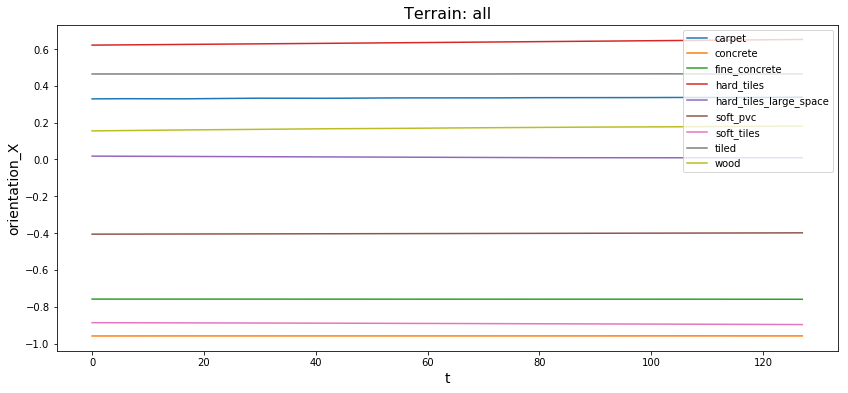

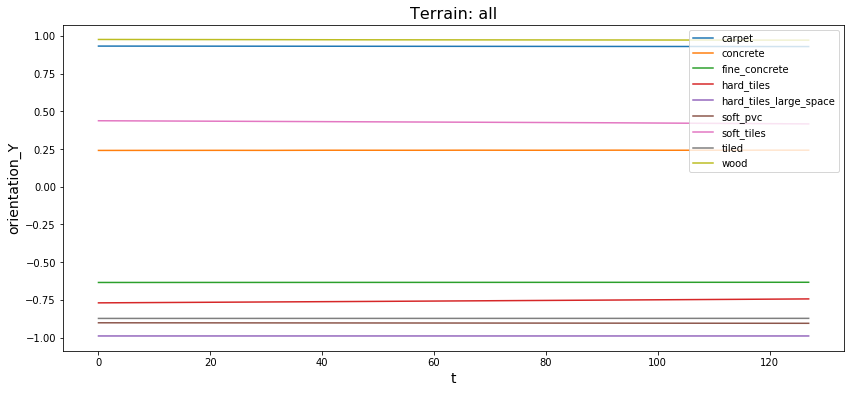

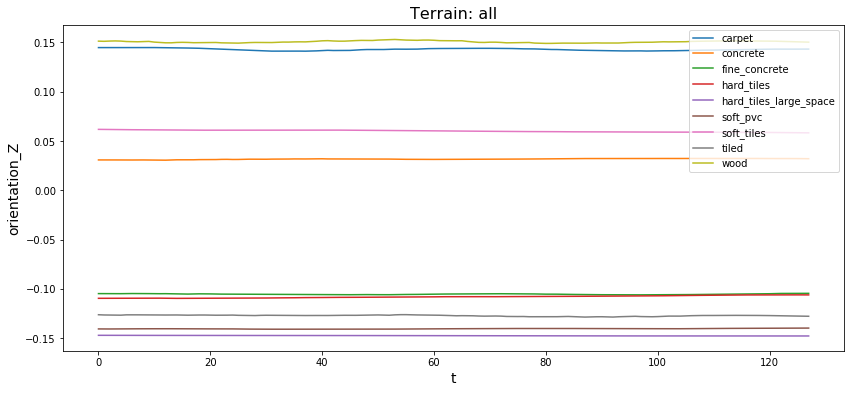

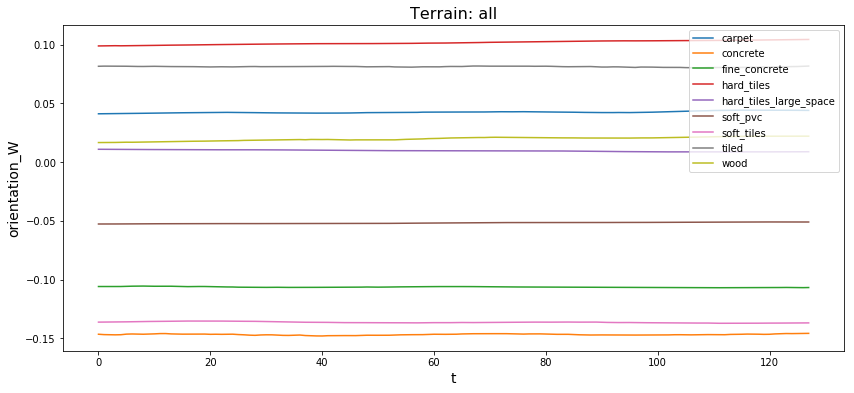

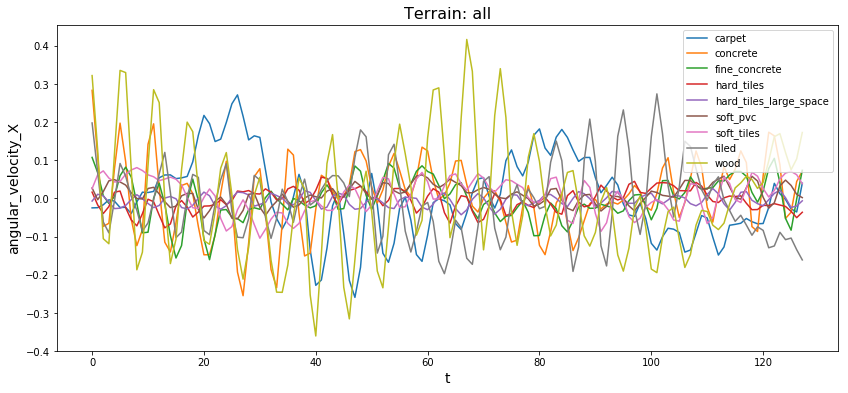

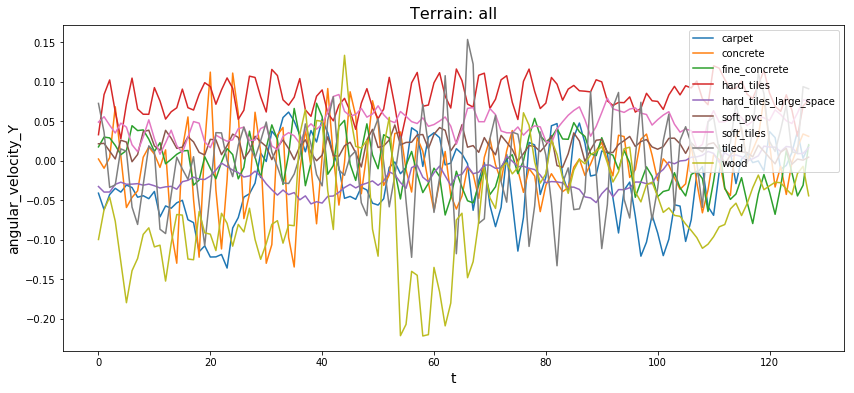

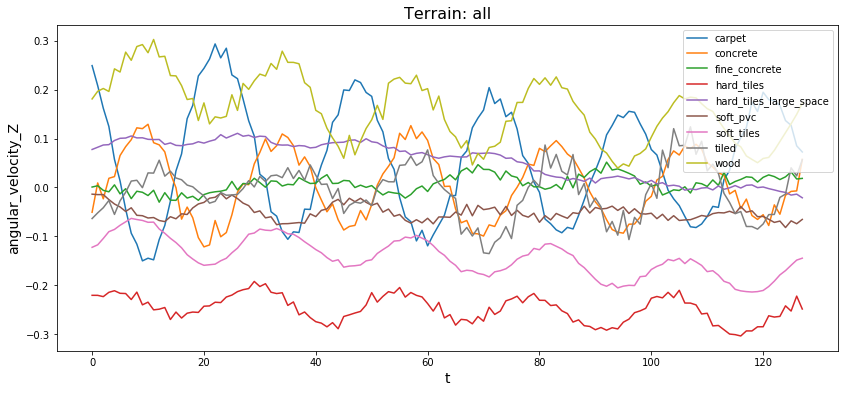

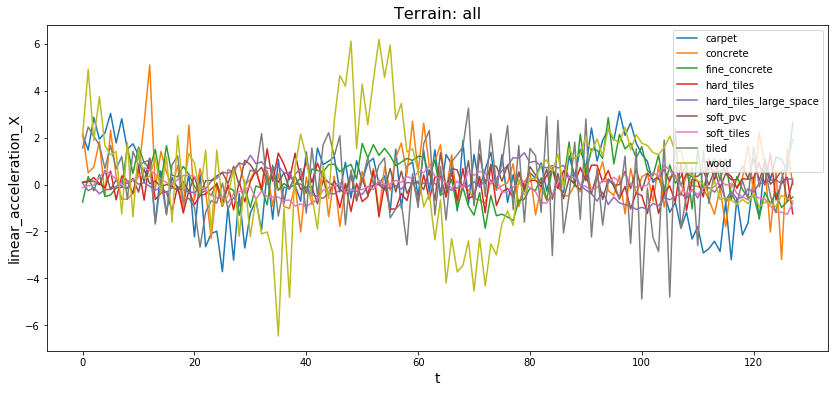

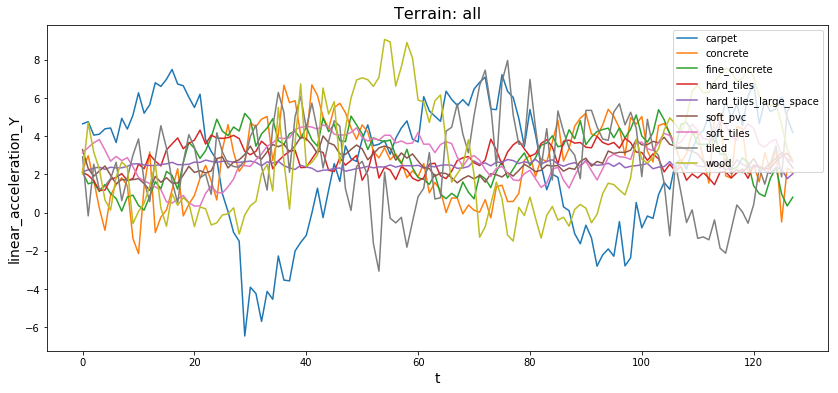

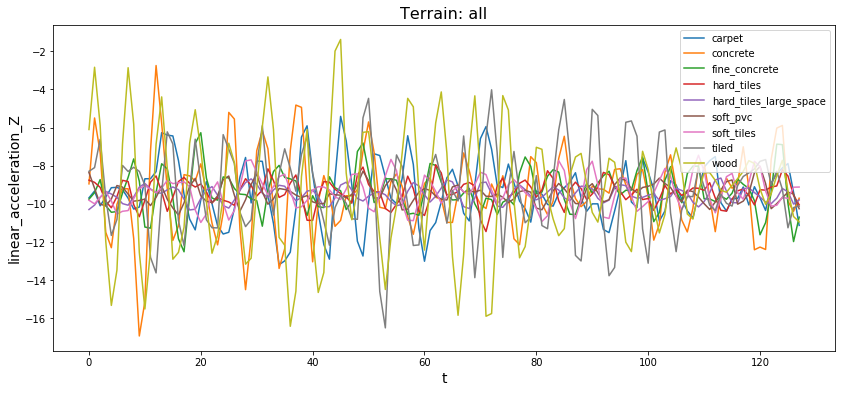

In [8]:
for suff, name in zip(["ori_X", "ori_Y", "ori_Z", "ori_W", "ang_X", "ang_Y", "ang_Z", "acc_X", "acc_Y", "acc_Z"], 
                      list(X_train.columns[3:])):
    plt.figure(figsize = (14,6))
    for i in first_idx:
        plt.plot(eval("X_train_" + suff)[i], label = y_train['surface'][i])
    plt.xlabel('t', fontsize = 14)
    plt.ylabel(name, fontsize = 14)
    plt.legend(loc = 'upper right')
    plt.title('Terrain: all', fontsize = 16)
    plt.show()

We notice that the Y axis accelerations tend to oscillate around the value 2.5 (with oscillations due to friction), while the Z axis accelerations seem to oscillate around the value -9.5 rather than the expected ~ -9.8 due to gravity. The most likely interpretation of this is that the robot is actually moving on a tilted surface: indeed we have

In [9]:
print(round(-np.sqrt(X_train_acc_Z.mean()**2 + X_train_acc_Y.mean()**2), 3))

-9.8


and the numbers are compatible with an inclination of ~ -15 degrees. We will therefore remove this contribution likely due to gravity from the data:

In [10]:
X_train_acc_Y = X_train_acc_Y + np.sqrt(X_train_acc_Z.mean()**2 + X_train_acc_Y.mean()**2)*np.sin(-15*np.pi/180)
X_train_acc_Z = X_train_acc_Z + np.sqrt(X_train_acc_Z.mean()**2 + X_train_acc_Y.mean()**2)*np.cos(-15*np.pi/180)

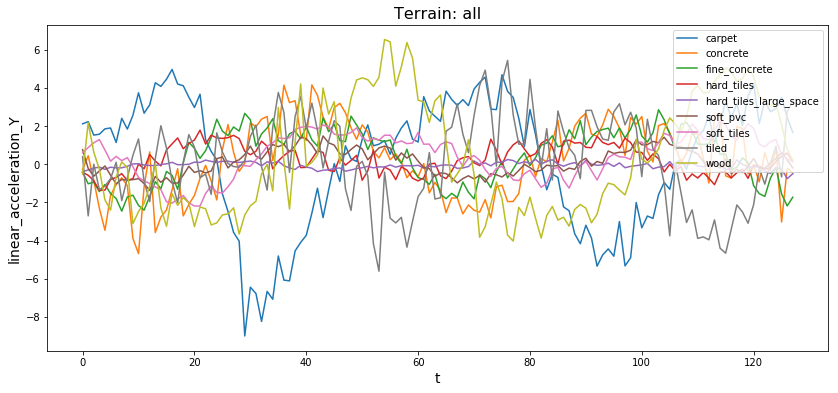

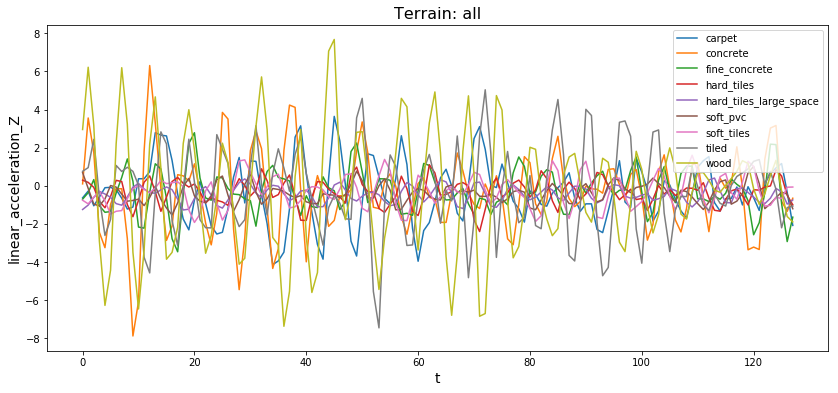

In [11]:
plt.figure(figsize = (14,6))
for i in first_idx:
    plt.plot(X_train_acc_Y[i], label = y_train['surface'][i])
plt.xlabel('t', fontsize = 14)
plt.ylabel("linear_acceleration_Y", fontsize = 14)
plt.legend(loc = 'upper right')
plt.title('Terrain: all', fontsize = 16)
plt.show()

plt.figure(figsize = (14,6))
for i in first_idx:
    plt.plot(X_train_acc_Z[i], label = y_train['surface'][i])
plt.xlabel('t', fontsize = 14)
plt.ylabel("linear_acceleration_Z", fontsize = 14)
plt.legend(loc = 'upper right')
plt.title('Terrain: all', fontsize = 16)
plt.show()

Finally, let us count the number of observations we have for each surface:

In [12]:
y_train['surface'].value_counts().sort_index()

carpet                    189
concrete                  779
fine_concrete             363
hard_tiles                 21
hard_tiles_large_space    308
soft_pvc                  732
soft_tiles                297
tiled                     514
wood                      607
Name: surface, dtype: int64

As we can see there are very few measurements for hard tiles, while we have a lot of measurements for concrete and soft pvc; we should therefore be careful since we are dealing with an **imbalanced dataset**.

***

## Literature investigation and feature engineering

Before starting analyzing the data, it may be helpful to look for literature discussing the problem, since this can give us ideas about which features and models are best suited for the task. Here there are some relevant papers one can find on the web: 

* https://pdfs.semanticscholar.org/9545/4071449e23d086d3dc290a9d36226e6efb9a.pdf


* https://www.researchgate.net/publication/254672013_Fundamentals_and_Methods_of_Terrain_Classification_Using_Proprioceptive_Sensors


* https://ac.els-cdn.com/S1877705812026537/1-s2.0-S1877705812026537-main.pdf?_tid=e0b2cf85-4a48-42d7-b24c-464bee9b0690&acdnat=1552722591_571fd2417f38ebe603e3aa5d8104ad46


* https://vtechworks.lib.vt.edu/bitstream/handle/10919/75181/Terrain%20Classification.pdf?sequence=1


* https://pdfs.semanticscholar.org/f8e2/2dfa40edf24bdbc8a047f17fcee2ca05350f.pdf


* http://www.carlandmelodee.com/Business/Papers/Freq_Response_Method.pdf


* https://www.researchgate.net/profile/Holger_Froehlich2/publication/221063478_Vibration-based_Terrain_Classification_Using_Support_Vector_Machines/links/09e415093df3777543000000.pdf


* https://pdfs.semanticscholar.org/eb07/e4cf4773319342f411e6eba9114cfc006577.pdf


* http://fsu.digital.flvc.org/islandora/object/fsu:180355/datastream/PDF/view


* https://www.researchgate.net/publication/331603183_Comparative_Study_of_Different_Methods_in_Vibration-Based_Terrain_Classification_for_Wheeled_Robots_with_Shock_Absorbers


* http://www.alexandrevicente.com/publications/Alexandre_Vicente_IROS2015_Final.pdf

After going through the literature, we realize that there are mainly two kind of features used for terrain classification in robotics:

* **Frequency-domain features**, i.e. location and amplitudes of the peaks either in the **discrete Fourier transform** or in the **log power spectral density** of the time series signal;


* **Time-domain features**, i.e. features that can be constructed in terms of the time series signal itself (such as mean, max, min values).

The main channel considered in the literature is the linear acceleration along the Z axis (which should be less sensitive about how the robot moves on the surface), sometimes in combination with the angular velocities along the X and Y axis; only more rarely all three linear accelerations and angular velocities are considered together, and I found no literature discussing the orientation channels (although I surely have missed many papers).

In addition, the literature provides some indication on which models may be more useful: older papers used either Support Vector Machines with time-domain features or shallow fully connected Neural Networks with frequency-domain features, while more recently Random Forest classifiers, Boosting classifiers and Convolutional/Recurrent Neural Networks started receiving more attention (with either time or frequency domain features).

With these considerations in mind, we will try considering various models trained either with time-domain or with frequency-domain features. 

Frequency-domain features simply correspond to the discrete Fourier transform and the power spectral density for the data in our channels (including also the orientation channels for completeness); these can be computed by using the Fast Fourier Transform function `np.fft.fft` implemented in Numpy and the `signal.welch` function implemented in Scipy:

In [13]:
X_train_acc_X_fft = np.array([ np.abs(np.fft.fft(X_train_acc_X[i]))[0:64] for i in range(X_train_acc_X.shape[0]) ])
X_train_acc_Y_fft = np.array([ np.abs(np.fft.fft(X_train_acc_Y[i]))[0:64] for i in range(X_train_acc_Y.shape[0]) ])
X_train_acc_Z_fft = np.array([ np.abs(np.fft.fft(X_train_acc_Z[i]))[0:64] for i in range(X_train_acc_Z.shape[0]) ])
X_train_ang_X_fft = np.array([ np.abs(np.fft.fft(X_train_ang_X[i]))[0:64] for i in range(X_train_ang_X.shape[0]) ])
X_train_ang_Y_fft = np.array([ np.abs(np.fft.fft(X_train_ang_Y[i]))[0:64] for i in range(X_train_ang_Y.shape[0]) ])
X_train_ang_Z_fft = np.array([ np.abs(np.fft.fft(X_train_ang_Z[i]))[0:64] for i in range(X_train_ang_Z.shape[0]) ])
X_train_ori_X_fft = np.array([ np.abs(np.fft.fft(X_train_ori_X[i]))[0:64] for i in range(X_train_ori_X.shape[0]) ])
X_train_ori_Y_fft = np.array([ np.abs(np.fft.fft(X_train_ori_Y[i]))[0:64] for i in range(X_train_ori_Y.shape[0]) ])
X_train_ori_Z_fft = np.array([ np.abs(np.fft.fft(X_train_ori_Z[i]))[0:64] for i in range(X_train_ori_Z.shape[0]) ])
X_train_ori_W_fft = np.array([ np.abs(np.fft.fft(X_train_ori_W[i]))[0:64] for i in range(X_train_ori_W.shape[0]) ])

# Set 'log = True' to compute the log power spectral density rather than the power spectral density itself

def get_psd(array, nperseg = 128, log = False):
    freqs, psd = scipy.signal.welch(array, nperseg = nperseg)
    if log == False:
        return psd[:,0:64]
    if log == True:
        return 10*np.log10(psd[:,0:64])

X_train_acc_X_psd = get_psd(X_train_acc_X)
X_train_acc_Y_psd = get_psd(X_train_acc_Y)
X_train_acc_Z_psd = get_psd(X_train_acc_Z)
X_train_ang_X_psd = get_psd(X_train_ang_X)
X_train_ang_Y_psd = get_psd(X_train_ang_Y)
X_train_ang_Z_psd = get_psd(X_train_ang_Z)
X_train_ori_X_psd = get_psd(X_train_ori_X)
X_train_ori_Y_psd = get_psd(X_train_ori_Y)
X_train_ori_Z_psd = get_psd(X_train_ori_Z)
X_train_ori_W_psd = get_psd(X_train_ori_W)

Let us plot such features for the first observation for each type of terrain in the linear acceleration Z channel (notice that we only consider the range [0:64] since the discrete Fourier transform of a real signal is symmetric with respect to the central value):

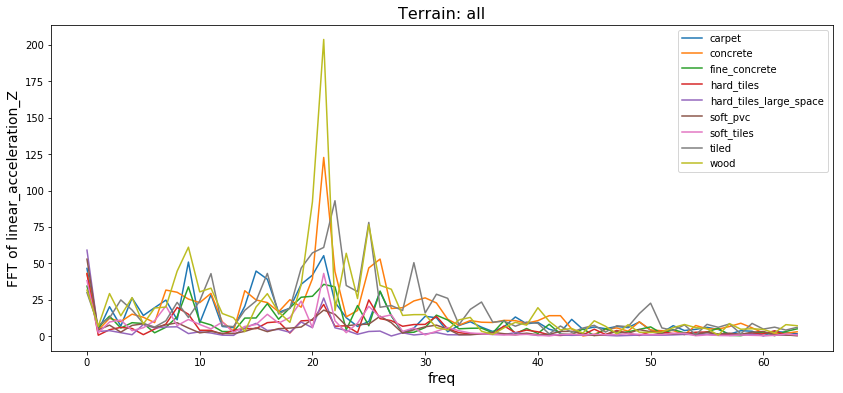

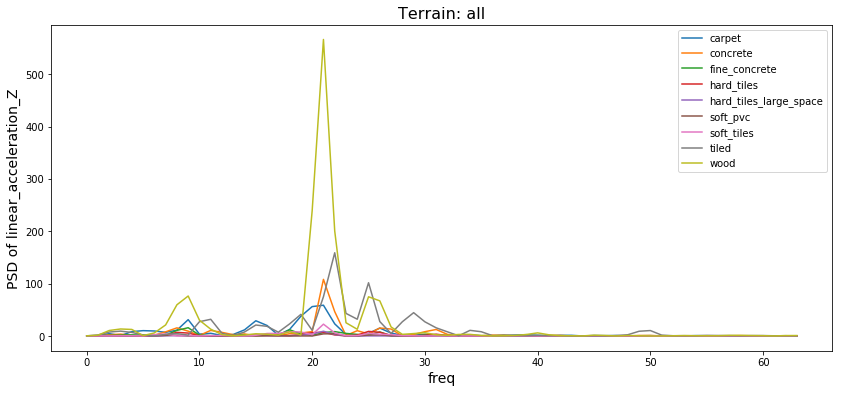

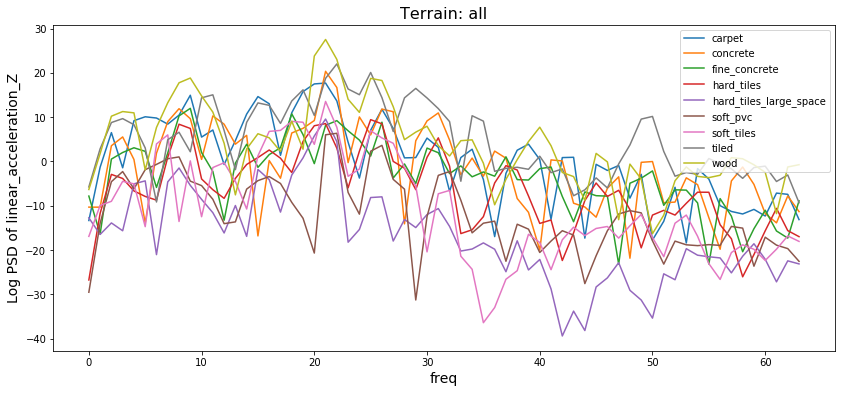

In [14]:
plt.figure(figsize = (14,6))
for i in first_idx:
    plt.plot(X_train_acc_Z_fft[i], label = y_train['surface'][i])
plt.xlabel('freq', fontsize = 14)
plt.ylabel("FFT of linear_acceleration_Z", fontsize = 14)
plt.legend(loc = 'upper right')
plt.title('Terrain: all', fontsize = 16)
plt.show()

plt.figure(figsize = (14,6))
for i in first_idx:
    plt.plot(X_train_acc_Z_psd[i], label = y_train['surface'][i])
plt.xlabel('freq', fontsize = 14)
plt.ylabel("PSD of linear_acceleration_Z", fontsize = 14)
plt.legend(loc = 'upper right')
plt.title('Terrain: all', fontsize = 16)
plt.show()

plt.figure(figsize = (14,6))
for i in first_idx:
    plt.plot(get_psd(X_train_acc_Z, log = True)[i], label = y_train['surface'][i])
plt.xlabel('freq', fontsize = 14)
plt.ylabel("Log PSD of linear_acceleration_Z", fontsize = 14)
plt.legend(loc = 'upper right')
plt.title('Terrain: all', fontsize = 16)
plt.show()

Notice however that since the signals in our ten channels do not seem to be periodic in general (i.e. the final value is different from the initial one), it may be better to use **windowing** when computing the discrete Fourier transform. Windowing essentially means multiplying the time series observation by a window of finite length with an amplitude that varies smoothly toward zero at the edges, in such a way to make the endpoints of the wave signal meet: this will remove artificial frequencies not present in the original signal. We can for example use a Kaiser window (`np.kaiser`) with $\beta = 6$ (i.e. a Hanning window):

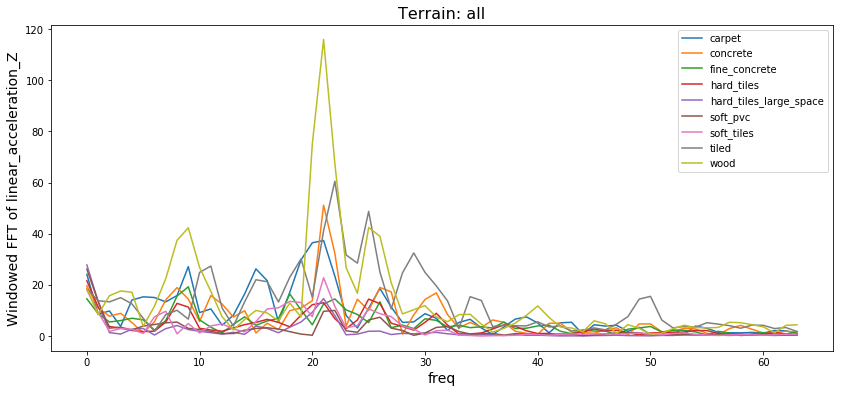

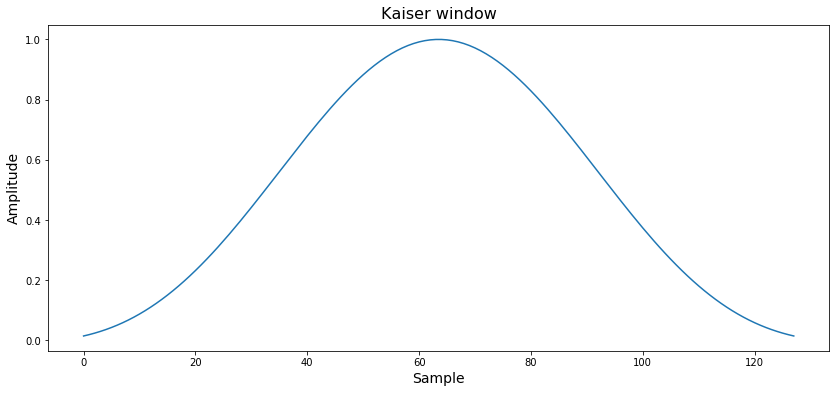

In [15]:
beta = 6

X_train_acc_X_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_acc_X[i]))[0:64] for i in range(X_train_acc_X.shape[0]) ])
X_train_acc_Y_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_acc_Y[i]))[0:64] for i in range(X_train_acc_Y.shape[0]) ])
X_train_acc_Z_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_acc_Z[i]))[0:64] for i in range(X_train_acc_Z.shape[0]) ])
X_train_ang_X_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_ang_X[i]))[0:64] for i in range(X_train_ang_X.shape[0]) ])
X_train_ang_Y_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_ang_Y[i]))[0:64] for i in range(X_train_ang_Y.shape[0]) ])
X_train_ang_Z_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_ang_Z[i]))[0:64] for i in range(X_train_ang_Z.shape[0]) ])
X_train_ori_X_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_ori_X[i]))[0:64] for i in range(X_train_ori_X.shape[0]) ])
X_train_ori_Y_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_ori_Y[i]))[0:64] for i in range(X_train_ori_Y.shape[0]) ])
X_train_ori_Z_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_ori_Z[i]))[0:64] for i in range(X_train_ori_Z.shape[0]) ])
X_train_ori_W_fft_win =\
np.array([ np.abs(np.fft.fft(np.kaiser(128, beta)*X_train_ori_W[i]))[0:64] for i in range(X_train_ori_W.shape[0]) ])

X_train_acc_X_psd_win = get_psd(np.kaiser(128, beta)*X_train_acc_X)
X_train_acc_Y_psd_win = get_psd(np.kaiser(128, beta)*X_train_acc_Y)
X_train_acc_Z_psd_win = get_psd(np.kaiser(128, beta)*X_train_acc_Z)
X_train_ang_X_psd_win = get_psd(np.kaiser(128, beta)*X_train_ang_X)
X_train_ang_Y_psd_win = get_psd(np.kaiser(128, beta)*X_train_ang_Y)
X_train_ang_Z_psd_win = get_psd(np.kaiser(128, beta)*X_train_ang_Z)
X_train_ori_X_psd_win = get_psd(np.kaiser(128, beta)*X_train_ori_X)
X_train_ori_Y_psd_win = get_psd(np.kaiser(128, beta)*X_train_ori_Y)
X_train_ori_Z_psd_win = get_psd(np.kaiser(128, beta)*X_train_ori_Z)
X_train_ori_W_psd_win = get_psd(np.kaiser(128, beta)*X_train_ori_W)

plt.figure(figsize = (14,6))
for i in first_idx:
    plt.plot(X_train_acc_Z_fft_win[i], label = y_train['surface'][i])
plt.xlabel('freq', fontsize = 14)
plt.ylabel("Windowed FFT of linear_acceleration_Z", fontsize = 14)
plt.legend(loc = 'upper right')
plt.title('Terrain: all', fontsize = 16)
plt.show()

plt.figure(figsize = (14,6))
plt.plot(np.kaiser(128, beta))
plt.xlabel("Sample", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.title("Kaiser window", fontsize = 16)
plt.show()

For what time-domain features are concerned, most of the literature suggest to use the following ones (for each channel of interest):

* Average number of times the signal crosses the mean value, which is an approximate estimation of the signal frequency 


* $\ell_2$ norm, which reflects the energy of the signal


* Mean, which expresses the average roughness of the surface


* Standard deviation, intuitively greater with a rougher ground surface


* Autocorrelation r, which is a measure of non-randomness


* Maximum


* Minimum


* Skewness


* Kurtosis

We can easily define a function to compute all these time-domain features at once for each time series observation:

In [16]:
def n_sign_changes(array):
    n_sign_changes = 0
    for i in range(len(array)-1):
        if np.sign(array[i]) != np.sign(array[i+1]):
            n_sign_changes += 1
    return n_sign_changes/len(array)

def n_traverses_over_number(array, number):
    return n_sign_changes(array - number)

def autocorr_lag1(array):
    return np.sum((array[:-1] - array.mean())*(array[1:] - array.mean()))/(len(array)*(array.std())**2)
    
def features(array):
    return np.array([ n_traverses_over_number(array, array.mean()), np.linalg.norm(array)/len(array),
                      np.mean(array), array.std(), autocorr_lag1(array),  
                      np.max(array), np.min(array),
                      scipy.stats.skew(array), scipy.stats.kurtosis(array) ])


X_train_acc_X_feat = np.array([features(X_train_acc_X[i]) for i in range(X_train_acc_X.shape[0])])
X_train_acc_Y_feat = np.array([features(X_train_acc_Y[i]) for i in range(X_train_acc_Y.shape[0])])
X_train_acc_Z_feat = np.array([features(X_train_acc_Z[i]) for i in range(X_train_acc_Z.shape[0])])
X_train_ang_X_feat = np.array([features(X_train_ang_X[i]) for i in range(X_train_ang_X.shape[0])])
X_train_ang_Y_feat = np.array([features(X_train_ang_Y[i]) for i in range(X_train_ang_Y.shape[0])])
X_train_ang_Z_feat = np.array([features(X_train_ang_Z[i]) for i in range(X_train_ang_Z.shape[0])])
X_train_ori_X_feat = np.array([features(X_train_ori_X[i]) for i in range(X_train_ori_X.shape[0])])
X_train_ori_Y_feat = np.array([features(X_train_ori_Y[i]) for i in range(X_train_ori_Y.shape[0])])
X_train_ori_Z_feat = np.array([features(X_train_ori_Z[i]) for i in range(X_train_ori_Z.shape[0])])
X_train_ori_W_feat = np.array([features(X_train_ori_W[i]) for i in range(X_train_ori_W.shape[0])])

***

## Data analysis

We can now start to look at our data a bit more in detail. Since different group id will likely correspond to different experimental conditions (even if the surface is the same), it seems more reasonable to look at the data group by group, in all possible channels. Let us therefore create a few lists containing the groups corresponding to the same terrain:

In [17]:
groups = sorted(y_train['group_id'].unique())
print("Number of observation groups:", len(groups))

groups_carpet = sorted(y_train.iloc[carpet_idx]['group_id'].unique())
groups_concrete = sorted(y_train.iloc[concrete_idx]['group_id'].unique())
groups_fine_concrete = sorted(y_train.iloc[fine_concrete_idx]['group_id'].unique())
groups_hard_tiles = sorted(y_train.iloc[hard_tiles_idx]['group_id'].unique())
groups_hard_tiles_large_space = sorted(y_train.iloc[hard_tiles_large_space_idx]['group_id'].unique())
groups_soft_pvc = sorted(y_train.iloc[soft_pvc_idx]['group_id'].unique())
groups_soft_tiles = sorted(y_train.iloc[soft_tiles_idx]['group_id'].unique())
groups_tiled = sorted(y_train.iloc[tiled_idx]['group_id'].unique())
groups_wood = sorted(y_train.iloc[wood_idx]['group_id'].unique())

Number of observation groups: 73


In order to avoid showing too many plots, let us just summarize our main observations.

1. Looking at the discrete Fourier transform or power spectral density of the various channels (for example the linear acceleration Z) we see that the mean amplitude of the various peaks seems to be different for different terrains, however the standard deviation is often as large as the mean, also because of few observations (possibly outliers) quite different from the rest. We therefore expect that frequency-domain features may somehow fail in clearly distinguishing similar terrains, although they may work well for some very peculiar surface. Let us for example compare carpet with fine concrete:

7     56
25    51
52    11
60    71
Name: group_id, dtype: int64


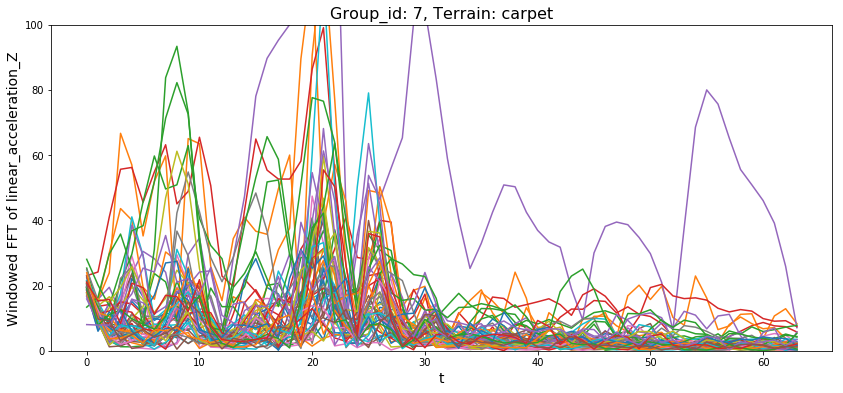

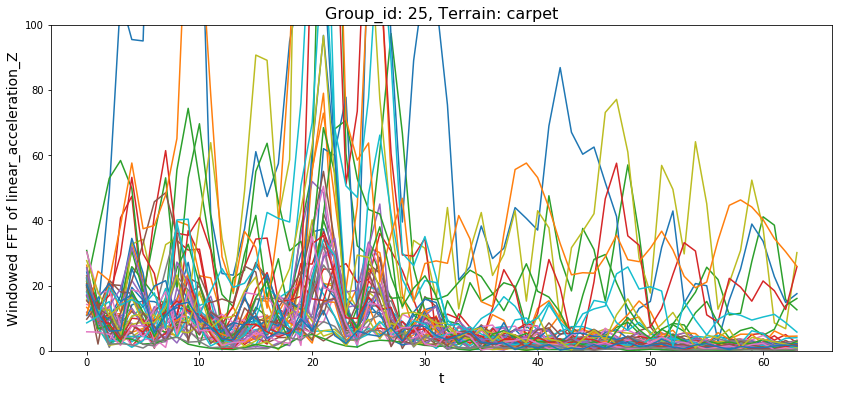

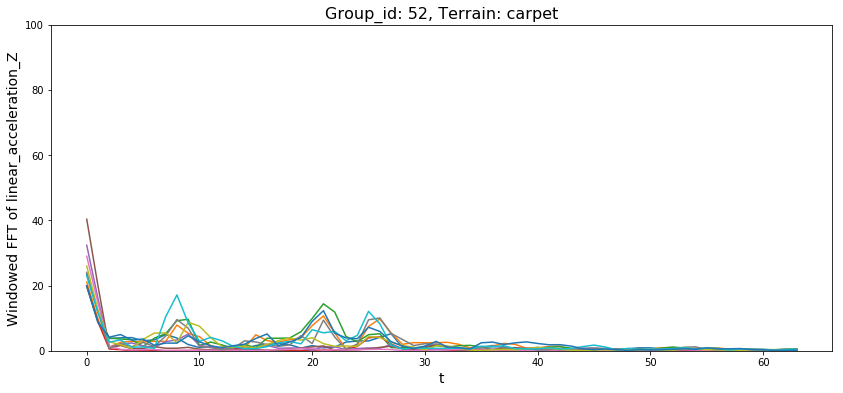

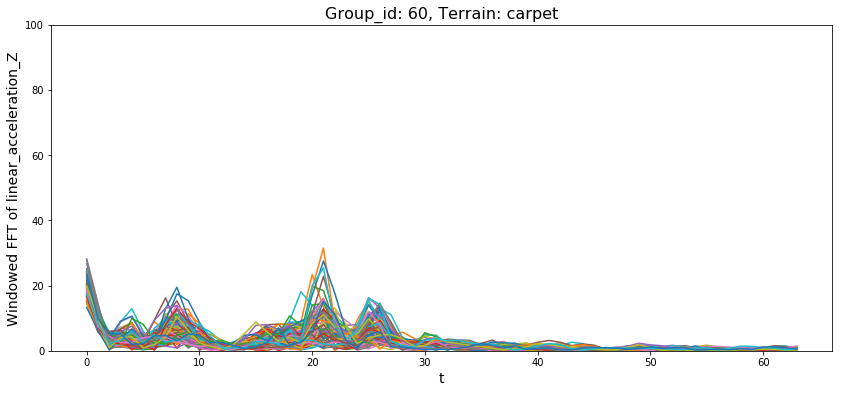

In [18]:
print(y_train['group_id'].iloc[carpet_idx].value_counts().sort_index())

for j in groups_carpet:
    
    plt.figure(figsize = (14,6))
    for i in list(y_train[y_train['group_id'] == groups[j]].index):
        plt.plot(X_train_acc_Z_fft_win[i])
    plt.xlabel('t', fontsize = 14)
    plt.ylabel('Windowed FFT of linear_acceleration_Z', fontsize = 14)
    plt.ylim([0,100])
    plt.title('Group_id: {}, Terrain: {}'.format(groups[j], 
                    y_train['surface'][list(y_train[y_train['group_id'] == groups[j]].index)[0]]), fontsize = 16)
    plt.show()

13    57
30     3
35    57
36    36
48    70
68    70
72    70
Name: group_id, dtype: int64


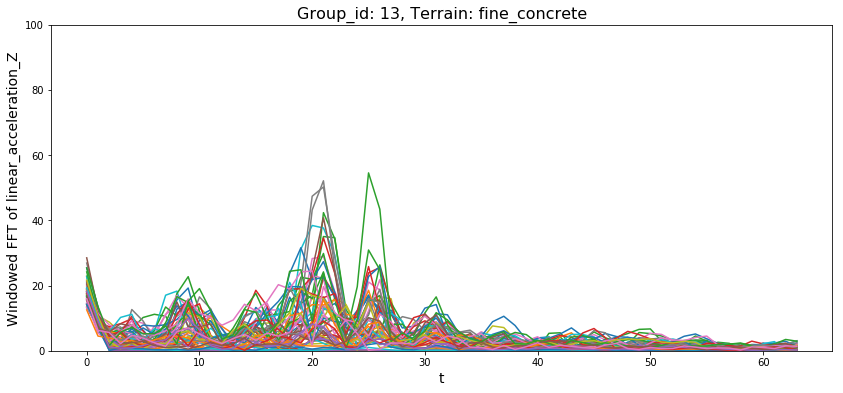

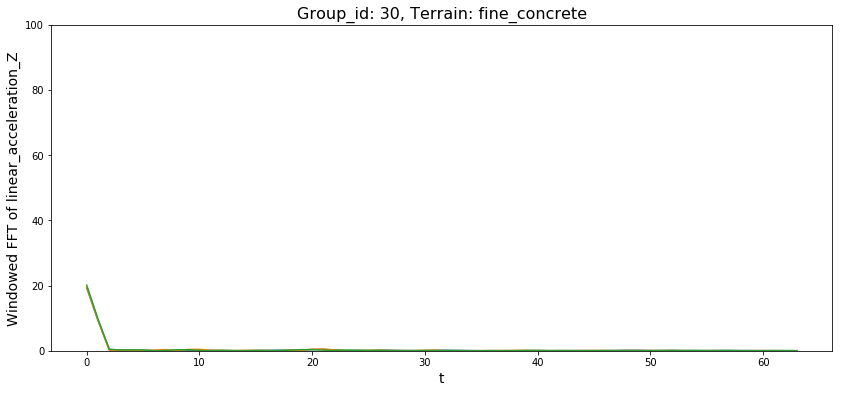

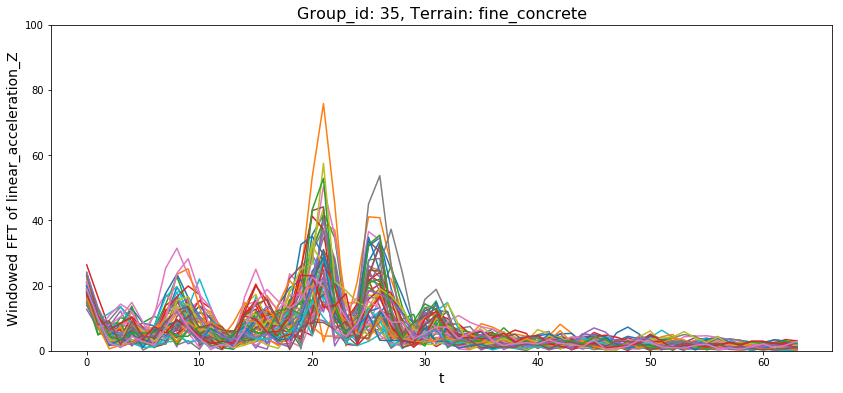

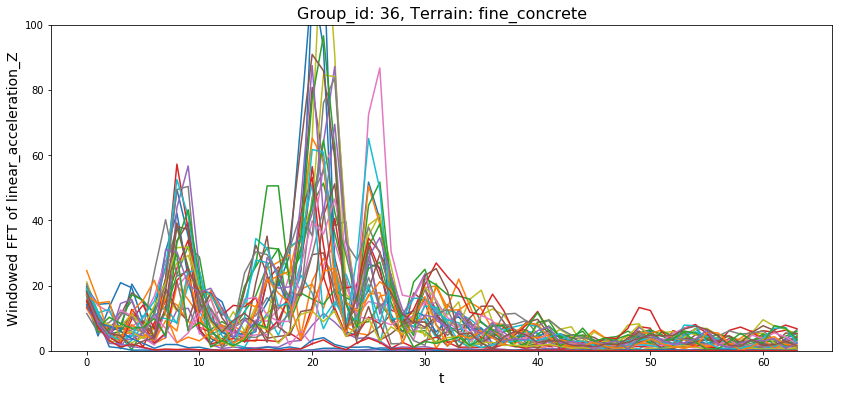

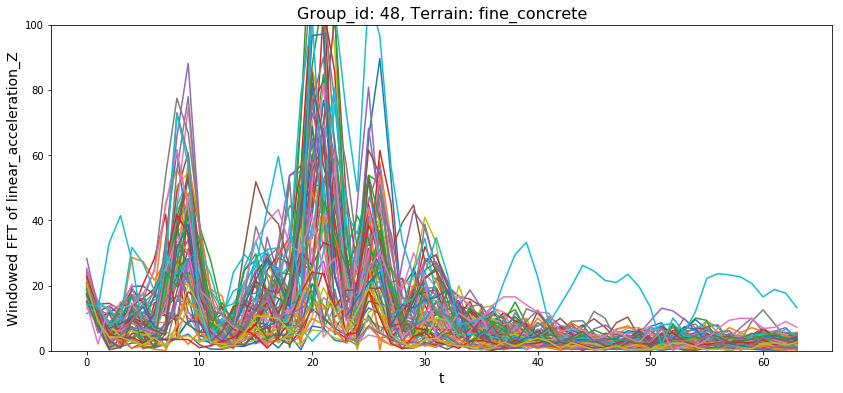

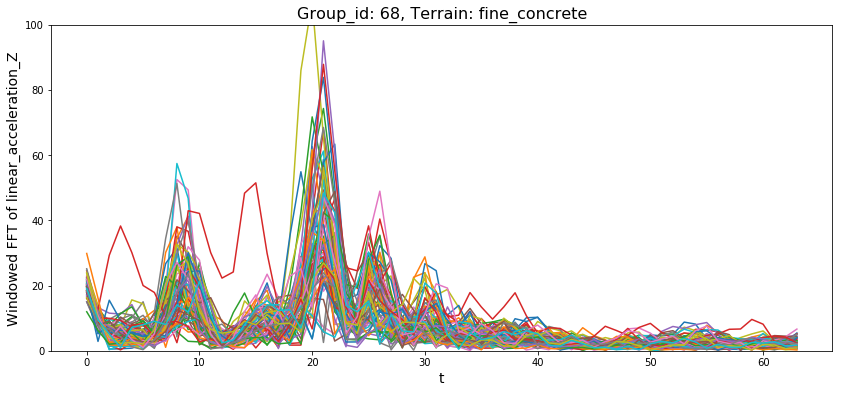

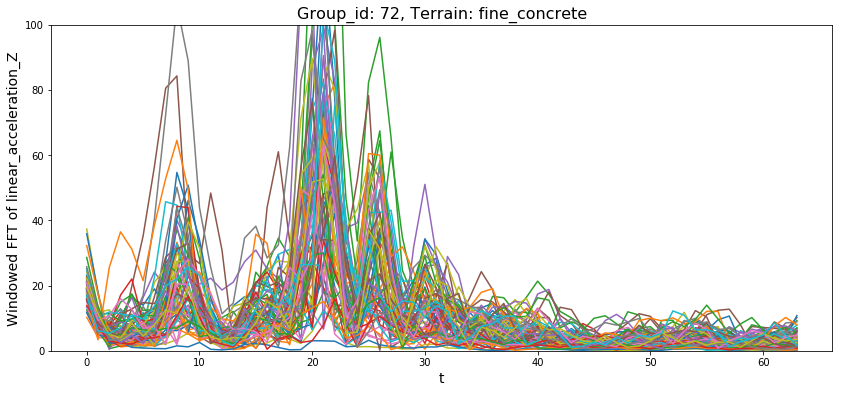

In [19]:
print(y_train['group_id'].iloc[fine_concrete_idx].value_counts().sort_index())

for j in groups_fine_concrete:
    
    plt.figure(figsize = (14,6))
    for i in list(y_train[y_train['group_id'] == groups[j]].index):
        plt.plot(X_train_acc_Z_fft_win[i])
    plt.xlabel('t', fontsize = 14)
    plt.ylabel('Windowed FFT of linear_acceleration_Z', fontsize = 14)
    plt.ylim([0,100])
    plt.title('Group_id: {}, Terrain: {}'.format(groups[j], 
                    y_train['surface'][list(y_train[y_train['group_id'] == groups[j]].index)[0]]), fontsize = 16)
    plt.show()

As we can see the mean of the peaks seems higher for fine concrete than for carpet, although the large standard deviation somehow obscures this property. More in general, we can visually compare the mean and standard deviations of the peaks (e.g. at frequencies 8 and 21) for the linear acceleration Z channel of all terrains:

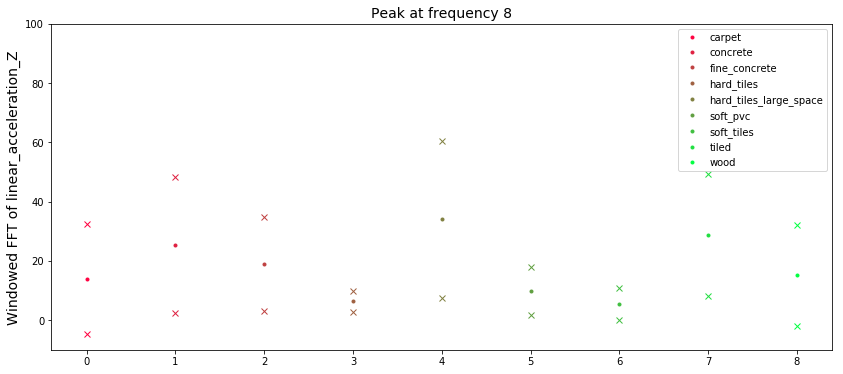

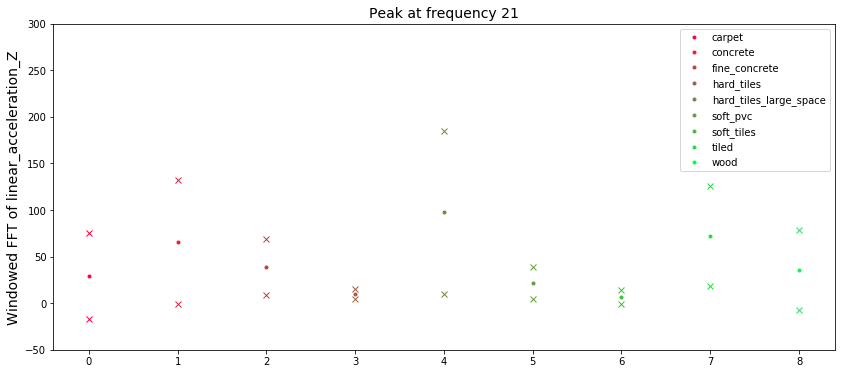

In [20]:
plt.figure(figsize = (14,6))
i = 0
for terrain in terrains:
    plt.plot(i, np.mean(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[8] 
             + np.std(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[8], 'x', color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[8], '.',
             label = terrain, color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[8] 
             - np.std(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[8], 'x', color = (1-i/8,0+i/8,0.25))
    i += 1
plt.legend()
plt.title('Peak at frequency 8', fontsize = 14)
plt.ylabel('Windowed FFT of linear_acceleration_Z', fontsize = 14)
plt.ylim([-10,100])
plt.show()

plt.figure(figsize = (14,6))
i = 0
for terrain in terrains:
    plt.plot(i, np.mean(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[21] 
             + np.std(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[21], 'x', color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[21], '.',
             label = terrain, color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[21] 
             - np.std(X_train_acc_Z_fft_win[eval(terrain + '_idx')], axis = 0)[21], 'x', color = (1-i/8,0+i/8,0.25))
    i += 1
plt.legend()
plt.title('Peak at frequency 21', fontsize = 14)
plt.ylabel('Windowed FFT of linear_acceleration_Z', fontsize = 14)
plt.ylim([-50,300])
plt.show()

From these plots it is clear that the mean of the peaks are different, but the standard deviations are quite large (although this effect may be somehow reduced by removing possible outliers). Peaks from different channels present similar characteristics; for example, for the discrete Fourier transform of angular velocity X:

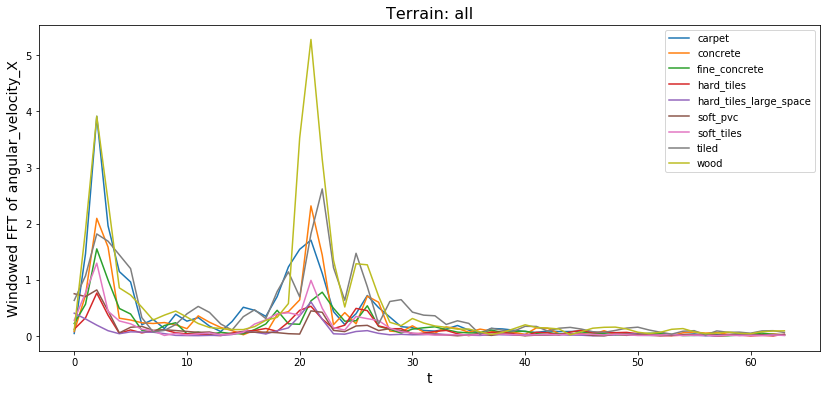

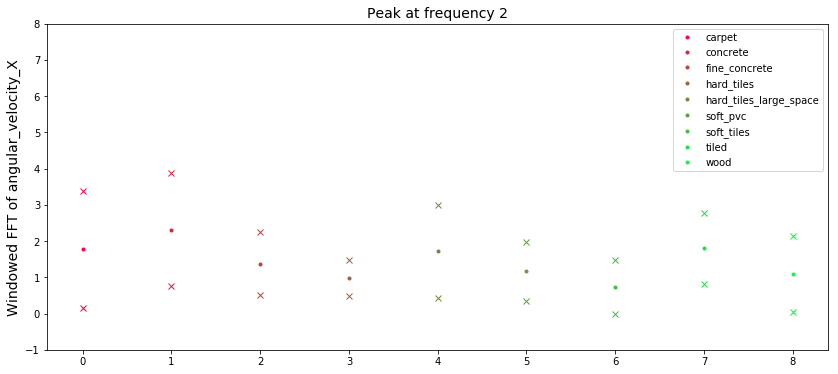

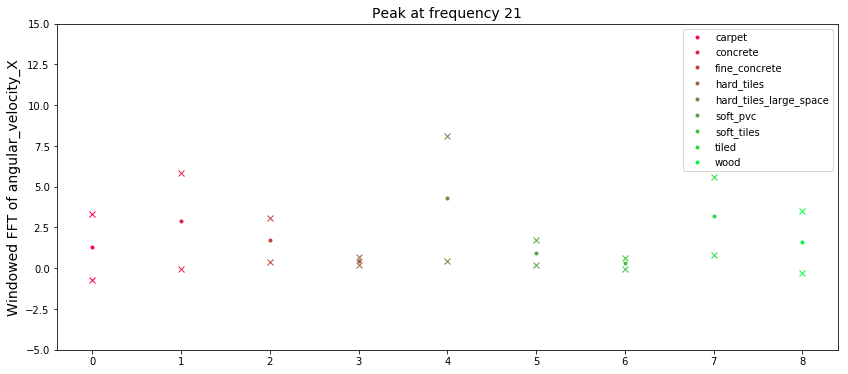

In [21]:
plt.figure(figsize = (14,6))
for i in first_idx:
    plt.plot(X_train_ang_X_fft_win[i], label = y_train['surface'][i])
plt.xlabel('t', fontsize = 14)
plt.ylabel("Windowed FFT of angular_velocity_X", fontsize = 14)
plt.legend(loc = 'upper right')
plt.title('Terrain: all', fontsize = 16)
plt.show()

plt.figure(figsize = (14,6))
i = 0
for terrain in terrains:
    plt.plot(i, np.mean(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[2] 
             + np.std(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[2], 'x', color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[2], '.',
             label = terrain, color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[2] 
             - np.std(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[2], 'x', color = (1-i/8,0+i/8,0.25))
    i += 1
plt.legend()
plt.title('Peak at frequency 2', fontsize = 14)
plt.ylabel('Windowed FFT of angular_velocity_X', fontsize = 14)
plt.ylim([-1,8])
plt.show()

plt.figure(figsize = (14,6))
i = 0
for terrain in terrains:
    plt.plot(i, np.mean(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[21] 
             + np.std(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[21], 'x', color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[21], '.',
             label = terrain, color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[21] 
             - np.std(X_train_ang_X_fft_win[eval(terrain + '_idx')], axis = 0)[21], 'x', color = (1-i/8,0+i/8,0.25))
    i += 1
plt.legend()
plt.title('Peak at frequency 21', fontsize = 14)
plt.ylabel('Windowed FFT of angular_velocity_X', fontsize = 14)
plt.ylim([-5,15])
plt.show()

2. The same problem affects the time-domain features; for example, for the linear acceleration Z channel:

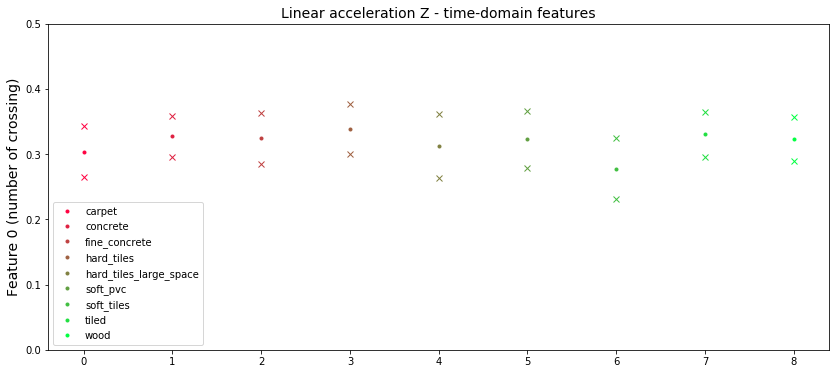

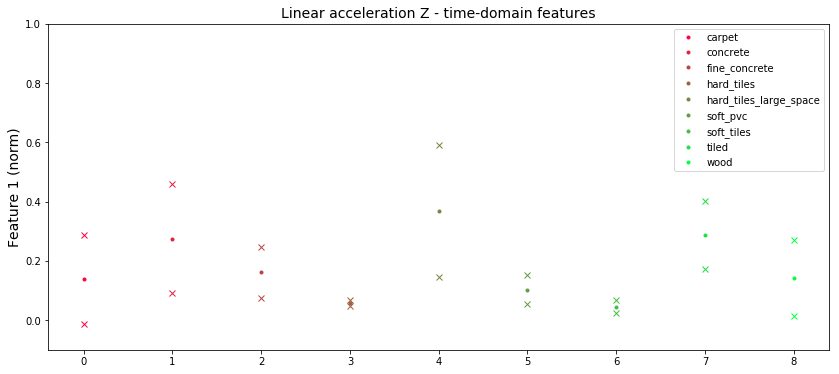

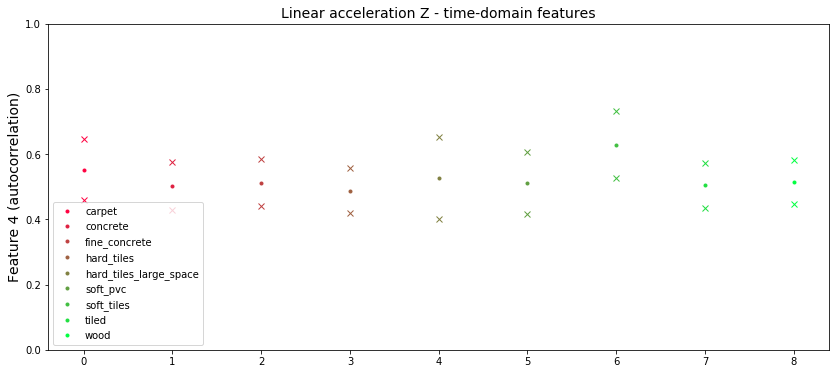

In [22]:
plt.figure(figsize = (14,6))
i = 0
for terrain in terrains:
    plt.plot(i, np.mean(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[0] 
             + np.std(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[0], 'x', color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[0], '.',
             label = terrain, color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[0] 
             - np.std(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[0], 'x', color = (1-i/8,0+i/8,0.25))
    i += 1
plt.legend()
plt.ylabel('Feature 0 (number of crossing)', fontsize = 14)
plt.title('Linear acceleration Z - time-domain features', fontsize = 14)
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize = (14,6))
i = 0
for terrain in terrains:
    plt.plot(i, np.mean(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[1] 
             + np.std(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[1], 'x', color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[1], '.',
             label = terrain, color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[1] 
             - np.std(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[1], 'x', color = (1-i/8,0+i/8,0.25))
    i += 1
plt.legend()
plt.ylabel('Feature 1 (norm)', fontsize = 14)
plt.title('Linear acceleration Z - time-domain features', fontsize = 14)
plt.ylim([-0.1,1])
plt.show()

plt.figure(figsize = (14,6))
i = 0
for terrain in terrains:
    plt.plot(i, np.mean(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[4] 
             + np.std(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[4], 'x', color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[4], '.',
             label = terrain, color = (1-i/8,0+i/8,0.25))
    plt.plot(i, np.mean(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[4] 
             - np.std(X_train_acc_Z_feat[eval(terrain + '_idx')], axis = 0)[4], 'x', color = (1-i/8,0+i/8,0.25))
    i += 1
plt.legend()
plt.ylabel('Feature 4 (autocorrelation)', fontsize = 14)
plt.title('Linear acceleration Z - time-domain features', fontsize = 14)
plt.ylim([0,1])
plt.show()

3. Different observations in the same group seems to actually be a single (or a few) longer observations divided in sub-samples of length 128. This is more evident if we look at the orientation channels, especially for those groups with a small number of observations. Let us illustrate this point by looking at the orientation X channel of group 67 (wood), which only has 6 observations:

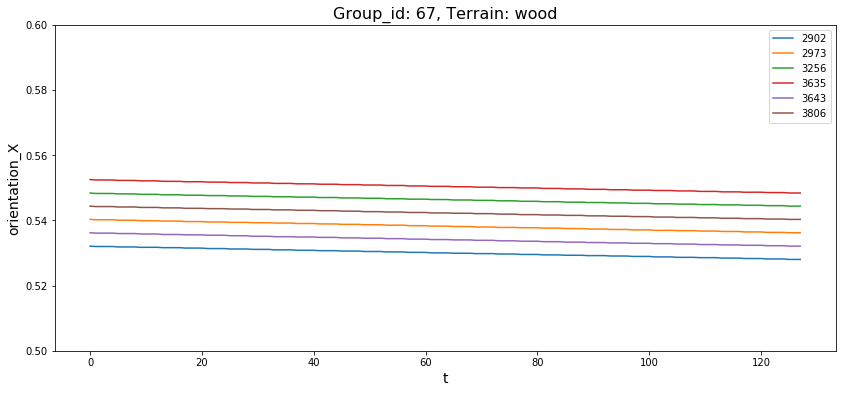

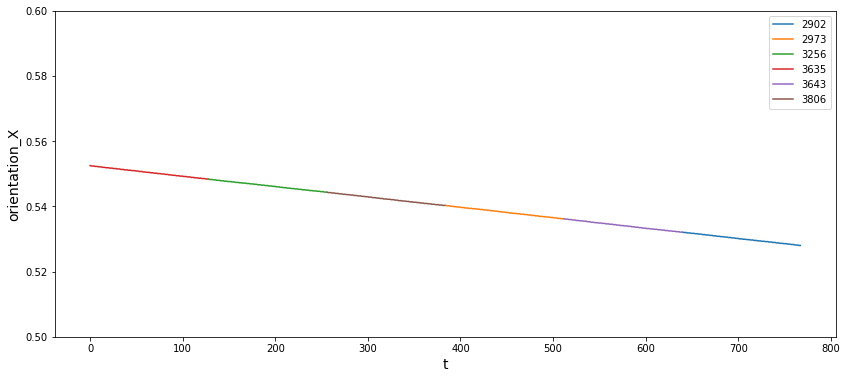

In [23]:
plt.figure(figsize = (14,6))
for i in list(y_train[y_train['group_id'] == 67].index):
    plt.plot(X_train_ori_X[i], label = i)
plt.xlabel('t', fontsize = 14)
plt.ylabel('orientation_X', fontsize = 14)
plt.ylim([0.5,0.6])
plt.legend()
plt.title('Group_id: {}, Terrain: {}'.format(67, 
                    y_train['surface'][list(y_train[y_train['group_id'] == 67].index)[0]]), fontsize = 16)
plt.show()

plt.figure(figsize = (14,6))
plt.plot(np.linspace(640, 767, 128), X_train_ori_X[2902], label = 2902)
plt.plot(np.linspace(384, 511, 128), X_train_ori_X[2973], label = 2973)
plt.plot(np.linspace(128, 255, 128), X_train_ori_X[3256], label = 3256)
plt.plot(np.linspace(0, 127, 128), X_train_ori_X[3635], label = 3635)
plt.plot(np.linspace(512, 639, 128), X_train_ori_X[3643], label = 3643)
plt.plot(np.linspace(256, 383, 128), X_train_ori_X[3806], label = 3806)
plt.xlabel('t', fontsize = 14)
plt.ylabel('orientation_X', fontsize = 14)
plt.ylim([0.5,0.6])
plt.legend()
plt.show()

The different observations nicely combine together into a longer one, also when considering different channels:

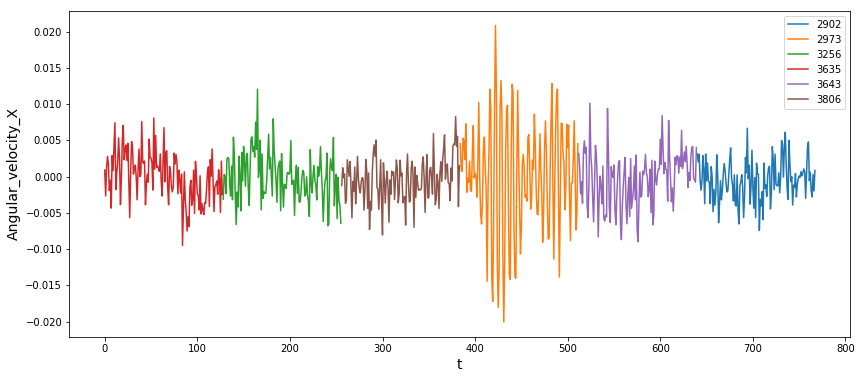

In [24]:
plt.figure(figsize = (14,6))
plt.plot(np.linspace(640, 767, 128), X_train_ang_X[2902], label = 2902)
plt.plot(np.linspace(384, 511, 128), X_train_ang_X[2973], label = 2973)
plt.plot(np.linspace(128, 255, 128), X_train_ang_X[3256], label = 3256)
plt.plot(np.linspace(0, 127, 128), X_train_ang_X[3635], label = 3635)
plt.plot(np.linspace(512, 639, 128), X_train_ang_X[3643], label = 3643)
plt.plot(np.linspace(256, 383, 128), X_train_ang_X[3806], label = 3806)
plt.xlabel('t', fontsize = 14)
plt.ylabel('Angular_velocity_X', fontsize = 14)
plt.legend()
plt.show()

To sum up:

* According to our observations, both frequency-domain and time-domain features may fail in distinguishing well similar terrains, but should be good enough to clearly distinguish terrains which are quite different from each other;


* Observations in the same group most likely belong to a single (or a few) longer observation, later divided in many parts;


* Removing outliers (group by group rather than surface by surface, to take into account possibly different experimental conditions) may help in reducing the standard deviation of our features; however this may also make us lose important information, especially if instances in the test set are a continuation of observations in the training set, because we may be dropping the time sequences connecting test and training set.

How to proceed at this point can only be determined by trying a few models and see how they perform.

***

## Models

Remember that we are dealing with an **imbalanced dataset**, in particular we have a very small number of hard tiles examples. This is usually problematic, since it is very likely that our models will be able to recognize well only the terrains for which we have more observations but will fail in recognizing surfaces for which we have less data. There are a few ways to partially alleviate such problem:

* We may give higher weights to observations of the less frequent classes (with `compute_sample_weight` in `sklearn.utils.class_weight`);


* We may use undersampling or oversampling (SMOTE, ADASYN) techniques (with `imblearn` library);


* Whenever possible, we may perform artificial **data augmentation**. For example, for our problem we may consider splitting each of our 128-measurement observations into two 64-measurement ones, especially if working with time-domain features (doing this with frequency-domain features will probably make us lose much information on the frequency spectrum, since shorter time sequences contain information only about lower frequencies).

In addition, our problem is a **multiclass classification** task: although the competition scoring is based on the **accuracy** on the test set, only by studying the **confusion matrix** we can understand if our model performs good in classifying all terrains of it just sees the ones for which we have more data.

There are many models we could try, so let us just present a few of them of different nature.

For starting, let us try a **SVM classifier** with Gaussian kernel as suggested by the literature we consulted. We will try both time-domain and frequency-domain features for the acceleration and angular velocity channels, and we will give different weights to different observations according to their frequency; in addition we will evaluate the model via cross-validation, stratifying the validation set according to the group id (which should take into account the fact that different groups probably correspond to different experimental conditions, although using stratification based on the surface gives similar results):

Time: 6.5409
Train accuracy (scale):      [0.4589122667725288, 0.44453186467348543, 0.43806174286830796] 
Average train accuracy: 0.44716862477144076
Validation accuracy (scale): [0.4198295894655306, 0.4274447949526814, 0.3964828137490008] 
Average validation accuracy: 0.4145857327224043


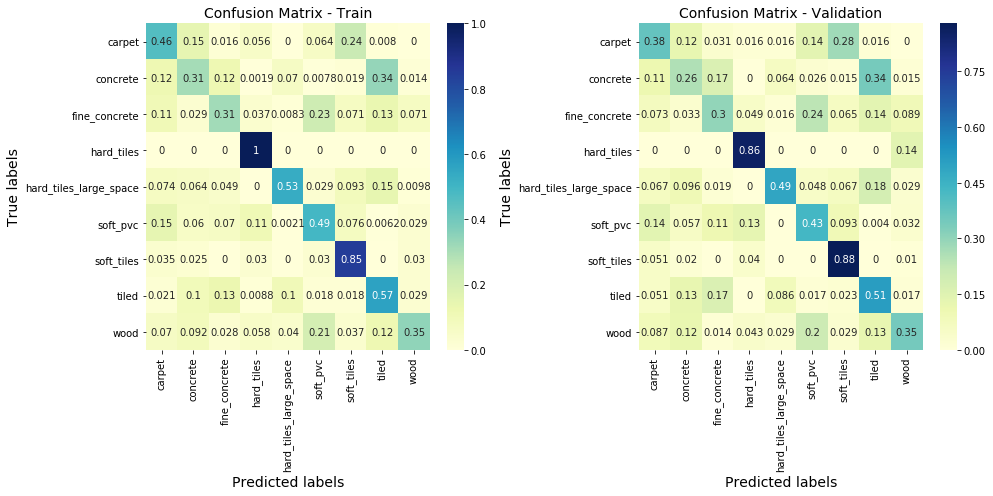

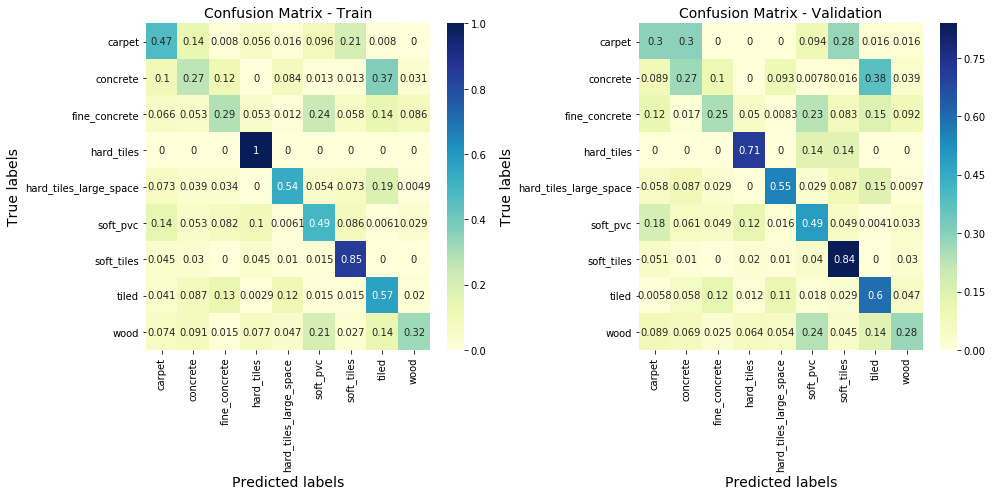

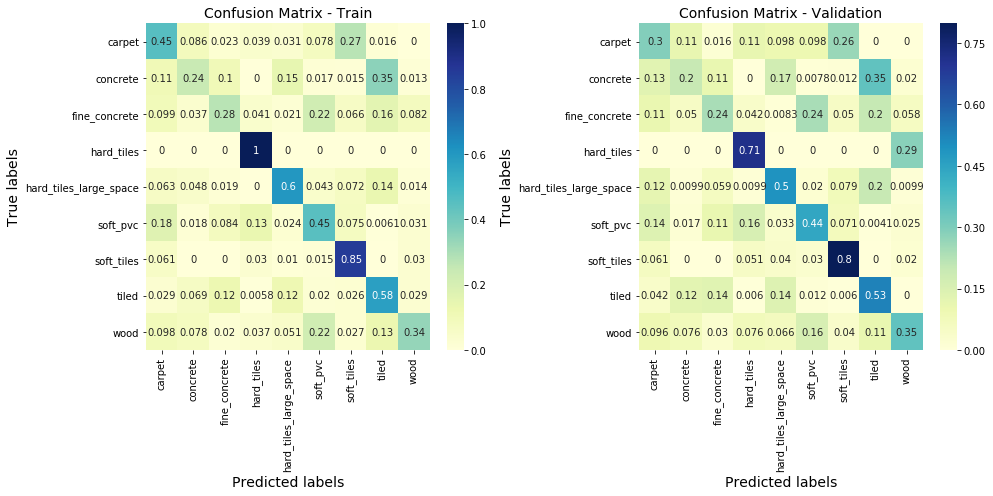

In [25]:
# Time-domain features

data_train = np.concatenate( (
    X_train_acc_X_feat, X_train_acc_Y_feat, X_train_acc_Z_feat, 
    X_train_ang_X_feat, X_train_ang_Y_feat, X_train_ang_Z_feat
    ), axis = 1)

data_train_red = data_train

y_train_red = y_train

train_acc = []
valid_acc = []

train_conf_mat = []
valid_conf_mat = []

from sklearn.svm import SVC  

svc_clf = SVC(C = 0.1, kernel = 'rbf', gamma = 'scale', class_weight = 'balanced')

from sklearn.model_selection import StratifiedKFold

split = StratifiedKFold(n_splits = 3, shuffle = True)

t0 = time()

for train_index, valid_index in split.split(data_train_red, y_train_red['group_id'].values):
        
    data_train_strat, y_train_strat = data_train_red[train_index], y_train_red['surface'].iloc[train_index].values
    data_valid_strat, y_valid_strat = data_train_red[valid_index], y_train_red['surface'].iloc[valid_index].values
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    
    data_train_strat = scaler.fit_transform(data_train_strat)
    data_valid_strat = scaler.transform(data_valid_strat)
    
    svc_clf.fit(data_train_strat, y_train_strat) 

    from sklearn.metrics import accuracy_score, confusion_matrix
        
    train_acc.append(accuracy_score(y_train_strat, svc_clf.predict(data_train_strat)))
    valid_acc.append(accuracy_score(y_valid_strat, svc_clf.predict(data_valid_strat)))
    
    train_conf_mat.append(confusion_matrix(y_train_strat, svc_clf.predict(data_train_strat)))
    valid_conf_mat.append(confusion_matrix(y_valid_strat, svc_clf.predict(data_valid_strat)))

t1 = time()

print("Time: {}".format(round(t1 - t0, 4)))

print("Train accuracy (scale):      {} \nAverage train accuracy: {}".format(train_acc, np.mean(train_acc)))
print("Validation accuracy (scale): {} \nAverage validation accuracy: {}".format(valid_acc, np.mean(valid_acc)))

for l in range(len(train_conf_mat)):
    plt.figure(figsize = (14,7))

    ax1 = plt.subplot(121)
    sns.heatmap(train_conf_mat[l]/np.sum(train_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax1, cmap="YlGnBu"); 
    ax1.set_xlabel('Predicted labels', fontsize = 14);
    ax1.set_ylabel('True labels', fontsize = 14);
    ax1.set_title('Confusion Matrix - Train', fontsize = 14);
    ax1.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax1.yaxis.set_ticklabels(terrains, rotation = 'horizontal');    

    ax2 = plt.subplot(122)
    sns.heatmap(valid_conf_mat[l]/np.sum(valid_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax2, cmap="YlGnBu"); 
    ax2.set_xlabel('Predicted labels', fontsize = 14);
    ax2.set_ylabel('True labels', fontsize = 14);
    ax2.set_title('Confusion Matrix - Validation', fontsize = 14);
    ax2.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax2.yaxis.set_ticklabels(terrains, rotation = 'horizontal');

    plt.tight_layout()
    plt.show()

Time: 43.3417
Train accuracy (scale):      [0.4672489082969432, 0.46380802517702596, 0.4869089488081282] 
Average train accuracy: 0.47265529409403245
Validation accuracy (scale): [0.447714949651433, 0.45110410094637227, 0.42046362909672264] 
Average validation accuracy: 0.43976089323150935


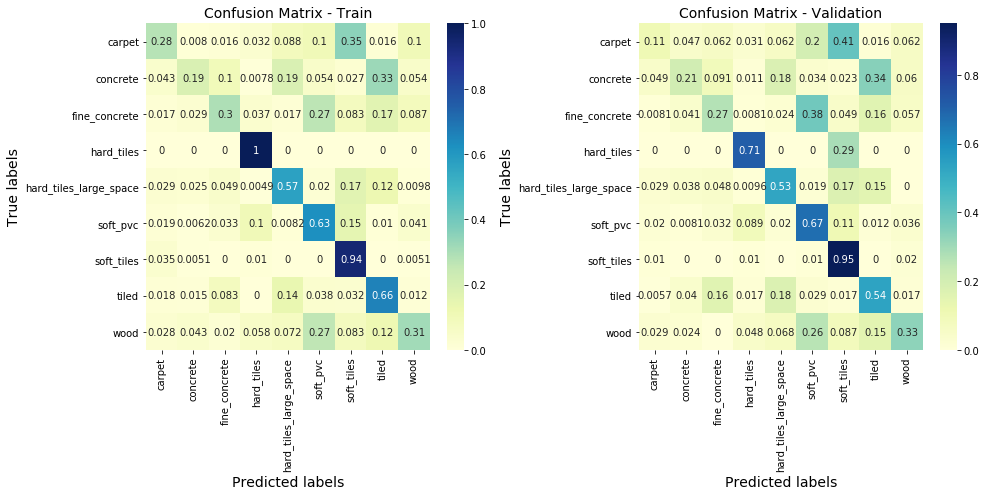

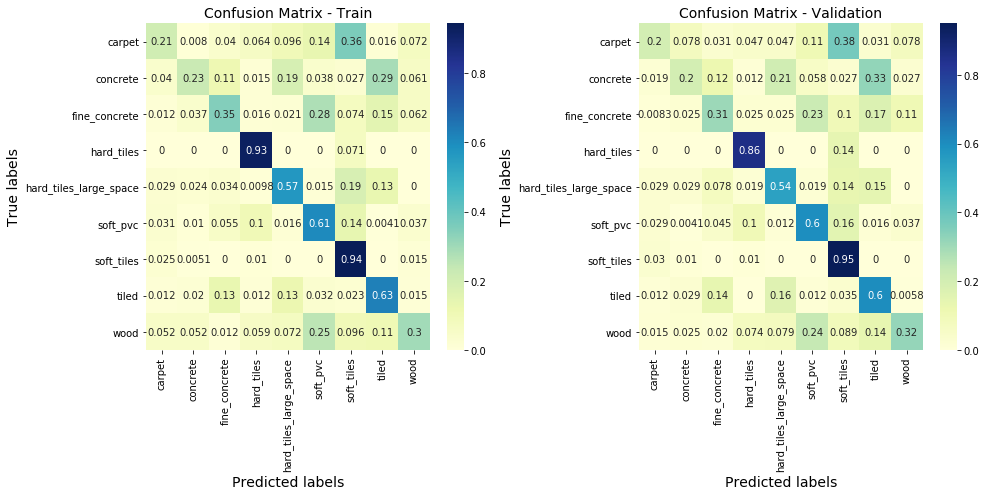

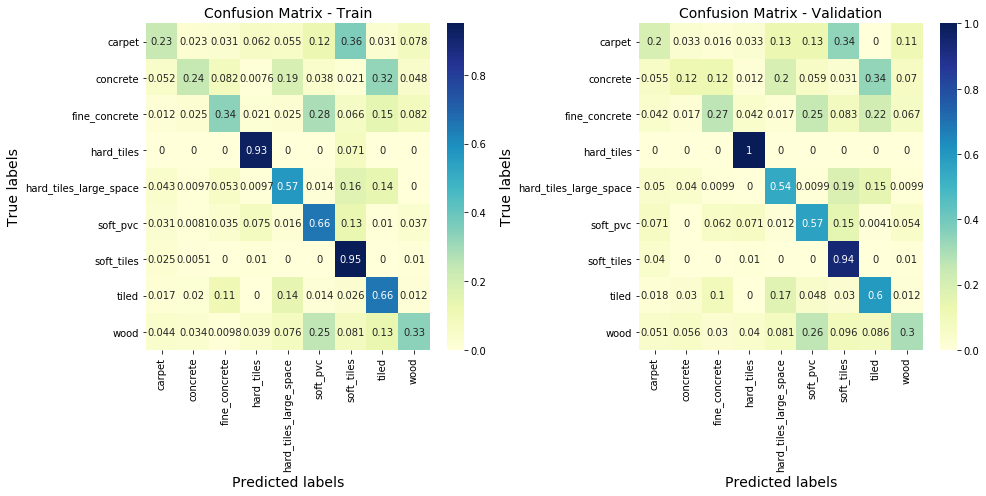

In [26]:
# Frequency-domain features

data_train = np.concatenate( (
    X_train_acc_X_fft_win, X_train_acc_Y_fft_win, X_train_acc_Z_fft_win, 
    X_train_ang_X_fft_win, X_train_ang_Y_fft_win, X_train_ang_Z_fft_win
    ), axis = 1)

data_train_red = data_train

y_train_red = y_train

train_acc = []
valid_acc = []

train_conf_mat = []
valid_conf_mat = []

from sklearn.svm import SVC  

svc_clf = SVC(C = 0.25, kernel = 'rbf', gamma = 'scale', class_weight = 'balanced')

from sklearn.model_selection import StratifiedKFold

split = StratifiedKFold(n_splits = 3, shuffle = True)

t0 = time()

for train_index, valid_index in split.split(data_train_red, y_train_red['group_id'].values):
        
    data_train_strat, y_train_strat = data_train_red[train_index], y_train_red['surface'].iloc[train_index].values
    data_valid_strat, y_valid_strat = data_train_red[valid_index], y_train_red['surface'].iloc[valid_index].values
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    
    data_train_strat = scaler.fit_transform(data_train_strat)
    data_valid_strat = scaler.transform(data_valid_strat)
    
    svc_clf.fit(data_train_strat, y_train_strat) 

    from sklearn.metrics import accuracy_score, confusion_matrix
        
    train_acc.append(accuracy_score(y_train_strat, svc_clf.predict(data_train_strat)))
    valid_acc.append(accuracy_score(y_valid_strat, svc_clf.predict(data_valid_strat)))
    
    train_conf_mat.append(confusion_matrix(y_train_strat, svc_clf.predict(data_train_strat)))
    valid_conf_mat.append(confusion_matrix(y_valid_strat, svc_clf.predict(data_valid_strat)))

t1 = time()

print("Time: {}".format(round(t1 - t0, 4)))

print("Train accuracy (scale):      {} \nAverage train accuracy: {}".format(train_acc, np.mean(train_acc)))
print("Validation accuracy (scale): {} \nAverage validation accuracy: {}".format(valid_acc, np.mean(valid_acc)))

for l in range(len(train_conf_mat)):
    plt.figure(figsize = (14,7))

    ax1 = plt.subplot(121)
    sns.heatmap(train_conf_mat[l]/np.sum(train_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax1, cmap="YlGnBu"); 
    ax1.set_xlabel('Predicted labels', fontsize = 14);
    ax1.set_ylabel('True labels', fontsize = 14);
    ax1.set_title('Confusion Matrix - Train', fontsize = 14);
    ax1.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax1.yaxis.set_ticklabels(terrains, rotation = 'horizontal');    

    ax2 = plt.subplot(122)
    sns.heatmap(valid_conf_mat[l]/np.sum(valid_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax2, cmap="YlGnBu"); 
    ax2.set_xlabel('Predicted labels', fontsize = 14);
    ax2.set_ylabel('True labels', fontsize = 14);
    ax2.set_title('Confusion Matrix - Validation', fontsize = 14);
    ax2.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax2.yaxis.set_ticklabels(terrains, rotation = 'horizontal');

    plt.tight_layout()
    plt.show()

Unfortunately these models seem to perform much worse than what expected from the literature consulted. We get the same bad performance also by using power spectral density features. We also tried using undersampling and oversampling (ADASYN) methods and even removing possible outliers, but all these procedures do not appear to considerably improve the model.

Let us next try the **convolutional + recurrent Neural Network** proposed in https://www.researchgate.net/publication/331603183_Comparative_Study_of_Different_Methods_in_Vibration-Based_Terrain_Classification_for_Wheeled_Robots_with_Shock_Absorbers. In this reference it was suggested to feed this Neural Network only the time series associated to the channel linear acceleration Z, after scaling the inputs to zero mean and unit variance. The architecture of the proposed Neurak Network, easily implemented via Keras, is as follows:

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, Reshape

dnn_clf = Sequential()
dnn_clf.add(Reshape(target_shape = [128,1], input_shape = [128]))
dnn_clf.add(Conv1D(filters = 8, kernel_size = 3, strides=1, padding='same', activation = 'selu', 
       kernel_initializer = 'lecun_normal'))
dnn_clf.add(MaxPooling1D(pool_size = 2, padding = 'same'))
dnn_clf.add(Conv1D(filters = 1, kernel_size = 1, strides=1, padding='same', activation = 'selu', 
       kernel_initializer = 'lecun_normal'))
dnn_clf.add(LSTM(units = 10, activation = 'tanh', recurrent_activation = 'sigmoid', 
                 kernel_initializer = 'glorot_normal', recurrent_initializer = 'orthogonal', dropout = 0.5, 
                 recurrent_dropout = 0.5, return_sequences = True))
dnn_clf.add(LSTM(units = 10, activation = 'tanh', recurrent_activation = 'sigmoid', 
                 kernel_initializer = 'glorot_normal', recurrent_initializer = 'orthogonal', dropout = 0.0, 
                 recurrent_dropout = 0.0))
dnn_clf.add( Dense(units = 9, activation = 'softmax') )

print(dnn_clf.summary())

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 8)            32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 1)             9         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_____________________________________________________________

Let us try to see how this performs:

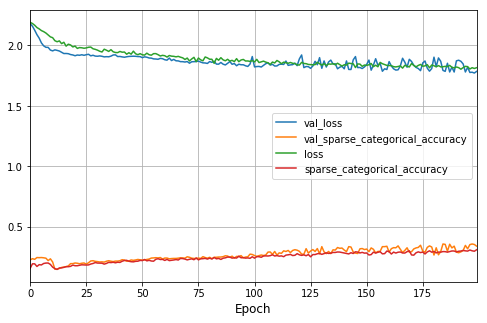

In [28]:
data_train = X_train_acc_Z

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25)

for train_index, valid_index in split.split(data_train, y_train['surface'].values):
        data_train_strat, y_train_strat = data_train[train_index], y_train['surface'].iloc[train_index].values
        data_valid_strat, y_valid_strat = data_train[valid_index], y_train['surface'].iloc[valid_index].values
        
y_train_strat_asint = np.array([terrains_dict.get(y_train_strat[j]) for j in range(len(y_train_strat))])
y_valid_strat_asint = np.array([terrains_dict.get(y_valid_strat[j]) for j in range(len(y_valid_strat))])

from sklearn.utils.class_weight import compute_sample_weight

sample_weight = compute_sample_weight(class_weight = 'balanced', y = y_train_strat_asint)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_train_strat = scaler.fit_transform(data_train_strat)
data_valid_strat = scaler.transform(data_valid_strat)        
    
dnn_clf.compile(loss = 'sparse_categorical_crossentropy',   # for int32/int64 labels in range [0, num_classes-1]
                    optimizer = 'RMSprop', metrics = ['sparse_categorical_accuracy'])

history = dnn_clf.fit(data_train_strat, y_train_strat_asint, batch_size = 256, epochs = 200, verbose = 0, 
                          validation_data = (data_valid_strat, y_valid_strat_asint), sample_weight = sample_weight)

pd.DataFrame(history.history).plot.line(figsize = (8,5))
plt.grid(True)
plt.xlabel("Epoch", fontsize = 12)
plt.show()

Once again, models taken from the literature do not seem to perform well for our problem. Trying to change hyperparameters, perform undersampling/oversampling, or artificially augmenting data by splitting each 128-measurement observation into two 64-measurement ones do not seem to substantially improve the model.

Finally, let us try **Gradient Boosting** models. We choose CatBoost, which is usually less prone to overfitting compared to XGBoost or LGBM. We will again consider time-domain features and freqency-domain features (we will not scale features since we are using Decision Tree boosting):

Time: 8.7094
Train accuracy (scale):      [0.4668519253672092, 0.479543666404406, 0.47284095349745997] 
Average train accuracy: 0.47307884842302506
Validation accuracy (scale): [0.4453911696359411, 0.43690851735015773, 0.45083932853717024] 
Average validation accuracy: 0.4443796718410897


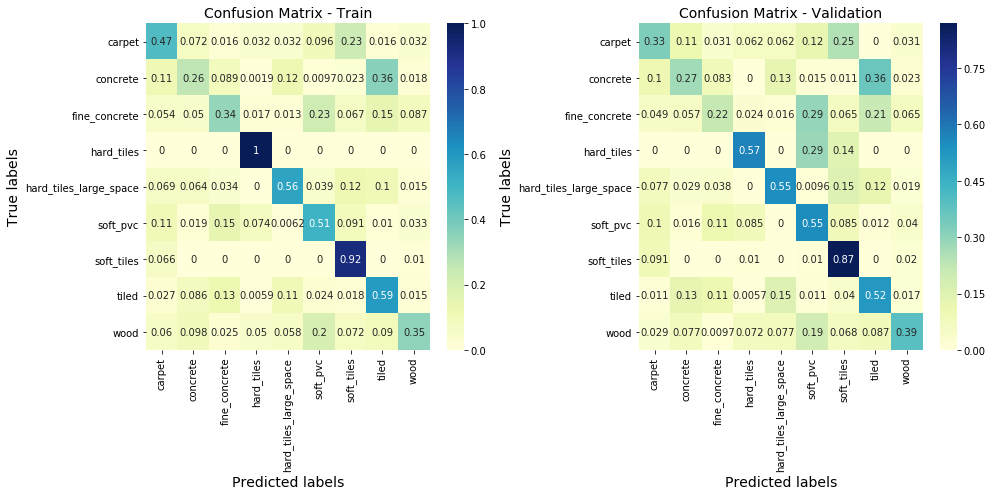

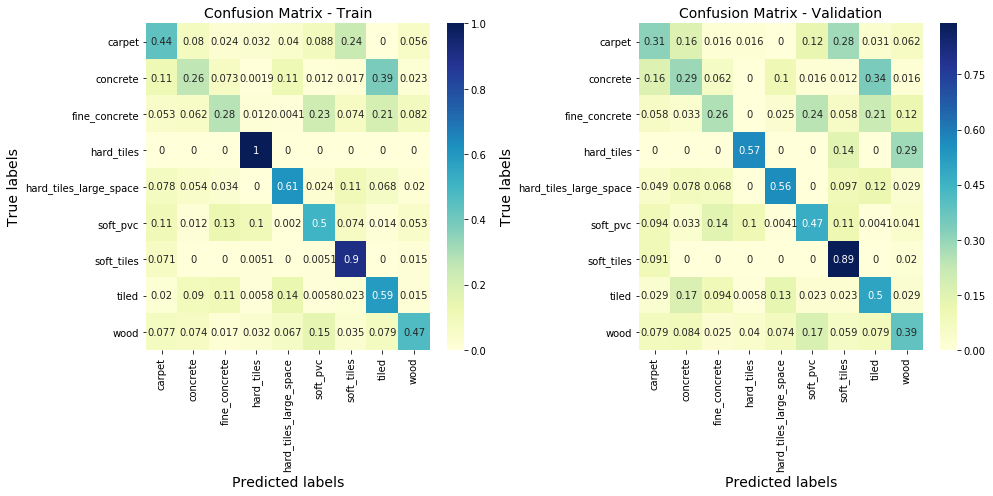

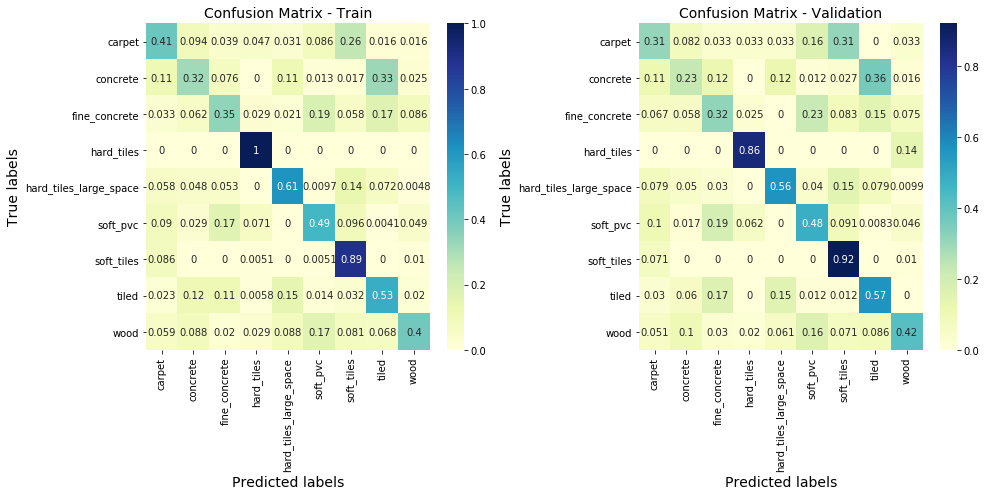

In [29]:
# Time-domain features

data_train = np.concatenate( (
    X_train_acc_X_feat, X_train_acc_Y_feat, X_train_acc_Z_feat, 
    X_train_ang_X_feat, X_train_ang_Y_feat, X_train_ang_Z_feat
    ), axis = 1)

data_train_red = data_train

y_train_red = y_train

train_acc = []
valid_acc = []

train_conf_mat = []
valid_conf_mat = []

from catboost import CatBoostClassifier

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'    

cbc_clf = CatBoostClassifier(classes_count = 9, loss_function = 'MultiClassOneVsAll', 
                             iterations = 400, depth = 3, l2_leaf_reg = 10.0, learning_rate = 0.02, 
                             model_size_reg = 0.5, boosting_type = 'Plain', random_strength = 1, rsm = 1)

from sklearn.model_selection import StratifiedKFold

split = StratifiedKFold(n_splits = 3, shuffle = True)

t0 = time()

for train_index, valid_index in split.split(data_train_red, y_train_red['group_id'].values):
        
    data_train_strat, y_train_strat = data_train_red[train_index], y_train_red['surface'].iloc[train_index].values
    data_valid_strat, y_valid_strat = data_train_red[valid_index], y_train_red['surface'].iloc[valid_index].values

    y_train_strat_asint = np.array([terrains_dict.get(y_train_strat[j]) for j in range(len(y_train_strat))])
    y_valid_strat_asint = np.array([terrains_dict.get(y_valid_strat[j]) for j in range(len(y_valid_strat))])

    from sklearn.utils.class_weight import compute_sample_weight

    sample_weight = compute_sample_weight(class_weight = 'balanced', y = y_train_strat_asint)
    
    cbc_clf.fit(data_train_strat, y_train_strat_asint, sample_weight = sample_weight, silent = True) 

    from sklearn.metrics import accuracy_score, confusion_matrix
        
    train_acc.append(accuracy_score(y_train_strat_asint, cbc_clf.predict(data_train_strat)))
    valid_acc.append(accuracy_score(y_valid_strat_asint, cbc_clf.predict(data_valid_strat)))
    
    train_conf_mat.append(confusion_matrix(y_train_strat_asint, cbc_clf.predict(data_train_strat)))
    valid_conf_mat.append(confusion_matrix(y_valid_strat_asint, cbc_clf.predict(data_valid_strat)))

t1 = time()

print("Time: {}".format(round(t1 - t0, 4)))

print("Train accuracy (scale):      {} \nAverage train accuracy: {}".format(train_acc, np.mean(train_acc)))
print("Validation accuracy (scale): {} \nAverage validation accuracy: {}".format(valid_acc, np.mean(valid_acc)))

for l in range(len(train_conf_mat)):
    plt.figure(figsize = (14,7))

    ax1 = plt.subplot(121)
    sns.heatmap(train_conf_mat[l]/np.sum(train_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax1, cmap="YlGnBu"); 
    ax1.set_xlabel('Predicted labels', fontsize = 14);
    ax1.set_ylabel('True labels', fontsize = 14);
    ax1.set_title('Confusion Matrix - Train', fontsize = 14);
    ax1.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax1.yaxis.set_ticklabels(terrains, rotation = 'horizontal');    

    ax2 = plt.subplot(122)
    sns.heatmap(valid_conf_mat[l]/np.sum(valid_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax2, cmap="YlGnBu"); 
    ax2.set_xlabel('Predicted labels', fontsize = 14);
    ax2.set_ylabel('True labels', fontsize = 14);
    ax2.set_title('Confusion Matrix - Validation', fontsize = 14);
    ax2.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax2.yaxis.set_ticklabels(terrains, rotation = 'horizontal');

    plt.tight_layout()
    plt.show()

Time: 38.407
Train accuracy (scale):      [0.5240174672489083, 0.530684500393391, 0.5205158264947245] 
Average train accuracy: 0.5250725980456746
Validation accuracy (scale): [0.44461657629744383, 0.4526813880126183, 0.4612310151878497] 
Average validation accuracy: 0.4528429931659706


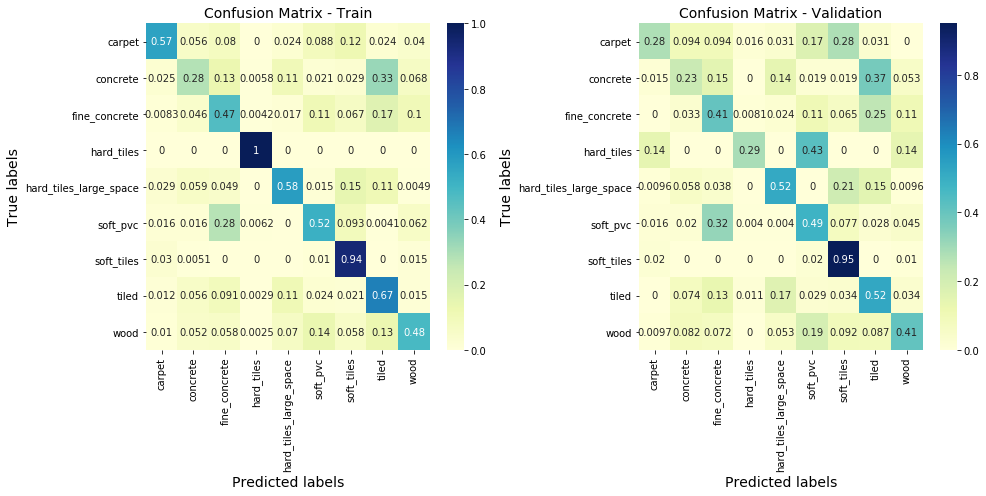

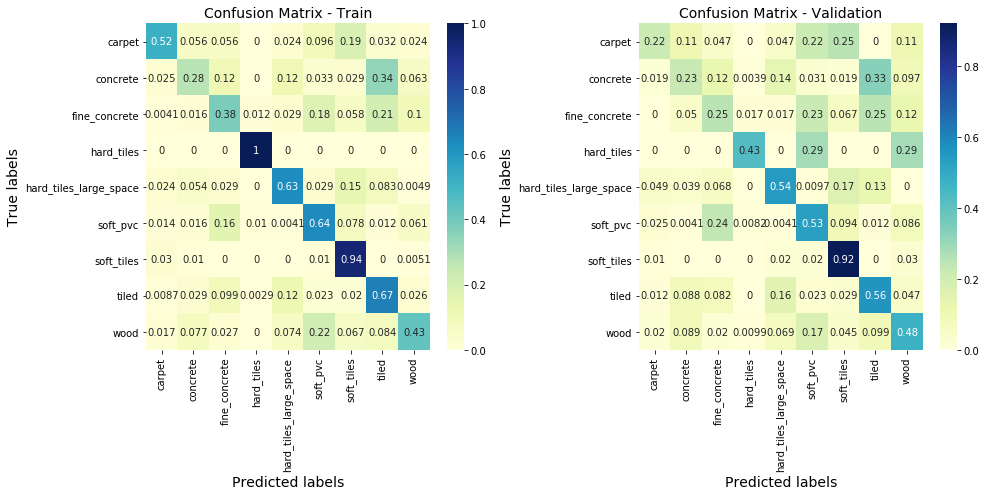

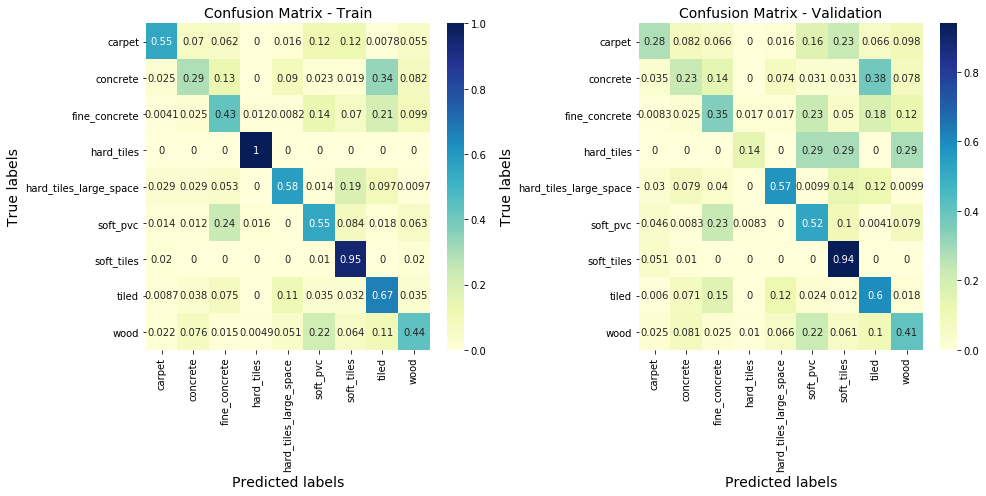

In [30]:
# Frequency-domain features

data_train = np.concatenate( (
    X_train_acc_X_fft_win, X_train_acc_Y_fft_win, X_train_acc_Z_fft_win, 
    X_train_ang_X_fft_win, X_train_ang_Y_fft_win, X_train_ang_Z_fft_win
    ), axis = 1)

data_train_red = data_train

y_train_red = y_train

train_acc = []
valid_acc = []

train_conf_mat = []
valid_conf_mat = []

from catboost import CatBoostClassifier

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'    

cbc_clf = CatBoostClassifier(classes_count = 9, loss_function = 'MultiClassOneVsAll', 
                             iterations = 400, depth = 3, l2_leaf_reg = 10.0, learning_rate = 0.03, 
                             model_size_reg = 0.5, boosting_type = 'Plain', random_strength = 1, rsm = 1)

from sklearn.model_selection import StratifiedKFold

split = StratifiedKFold(n_splits = 3, shuffle = True)

t0 = time()

for train_index, valid_index in split.split(data_train_red, y_train_red['group_id'].values):
        
    data_train_strat, y_train_strat = data_train_red[train_index], y_train_red['surface'].iloc[train_index].values
    data_valid_strat, y_valid_strat = data_train_red[valid_index], y_train_red['surface'].iloc[valid_index].values

    y_train_strat_asint = np.array([terrains_dict.get(y_train_strat[j]) for j in range(len(y_train_strat))])
    y_valid_strat_asint = np.array([terrains_dict.get(y_valid_strat[j]) for j in range(len(y_valid_strat))])

    from sklearn.utils.class_weight import compute_sample_weight

    sample_weight = compute_sample_weight(class_weight = 'balanced', y = y_train_strat_asint)
    
    cbc_clf.fit(data_train_strat, y_train_strat_asint, sample_weight = sample_weight, silent = True) 

    from sklearn.metrics import accuracy_score, confusion_matrix
        
    train_acc.append(accuracy_score(y_train_strat_asint, cbc_clf.predict(data_train_strat)))
    valid_acc.append(accuracy_score(y_valid_strat_asint, cbc_clf.predict(data_valid_strat)))
    
    train_conf_mat.append(confusion_matrix(y_train_strat_asint, cbc_clf.predict(data_train_strat)))
    valid_conf_mat.append(confusion_matrix(y_valid_strat_asint, cbc_clf.predict(data_valid_strat)))

t1 = time()

print("Time: {}".format(round(t1 - t0, 4)))

print("Train accuracy (scale):      {} \nAverage train accuracy: {}".format(train_acc, np.mean(train_acc)))
print("Validation accuracy (scale): {} \nAverage validation accuracy: {}".format(valid_acc, np.mean(valid_acc)))

for l in range(len(train_conf_mat)):
    plt.figure(figsize = (14,7))

    ax1 = plt.subplot(121)
    sns.heatmap(train_conf_mat[l]/np.sum(train_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax1, cmap="YlGnBu"); 
    ax1.set_xlabel('Predicted labels', fontsize = 14);
    ax1.set_ylabel('True labels', fontsize = 14);
    ax1.set_title('Confusion Matrix - Train', fontsize = 14);
    ax1.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax1.yaxis.set_ticklabels(terrains, rotation = 'horizontal');    

    ax2 = plt.subplot(122)
    sns.heatmap(valid_conf_mat[l]/np.sum(valid_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax2, cmap="YlGnBu"); 
    ax2.set_xlabel('Predicted labels', fontsize = 14);
    ax2.set_ylabel('True labels', fontsize = 14);
    ax2.set_title('Confusion Matrix - Validation', fontsize = 14);
    ax2.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax2.yaxis.set_ticklabels(terrains, rotation = 'horizontal');

    plt.tight_layout()
    plt.show()

A nice property of CatBoost is that it tells us which features are more relevant for its decision processes; it is easy to check that, as expected, the relevant features correspond to the position of the peaks in the discrete Fourier transform:

In [31]:
importance_cbc = sorted(list(enumerate(cbc_clf.feature_importances_)), key=lambda x: x[1], reverse=True)

rel_cbc_idx = [importance_cbc[i][0] for i in range(len(importance_cbc))]

print("Index of first few relevant features (peaks position):\n{}".format(rel_cbc_idx[:20]))

Index of first few relevant features (peaks position):
[256, 320, 321, 132, 174, 161, 68, 59, 334, 139, 138, 191, 61, 45, 127, 257, 40, 128, 190, 81]


However once again, even this model does not seem to be very promising, even if we use power spectral density features in combination with discrete Fourier transform features or if we combine time-domain with frequency-domain features.

To sum up, none of the models considered seem to perform well enough by feeding them information only about linear acceleration and angular velocity. It is then natural at this point trying to feed the models our additional information about the orientation of the robot: after all we have already seen that observations in the same group are actually part of longer observations, and the orientation channels may be useful for the model to recognize which observation precedes or follows another observation. Indeed, by doing this the performance of the model greatly improves; for example, using discrete Fourier transform features for all 10 channels we get:

Time: 57.1269
Train accuracy (scale):      [0.6605795950774117, 0.6707317073170732, 0.6604142243063696] 
Average train accuracy: 0.6639085089002849
Validation accuracy (scale): [0.6142525174283501, 0.6246056782334385, 0.6219024780175859] 
Average validation accuracy: 0.6202535578931249


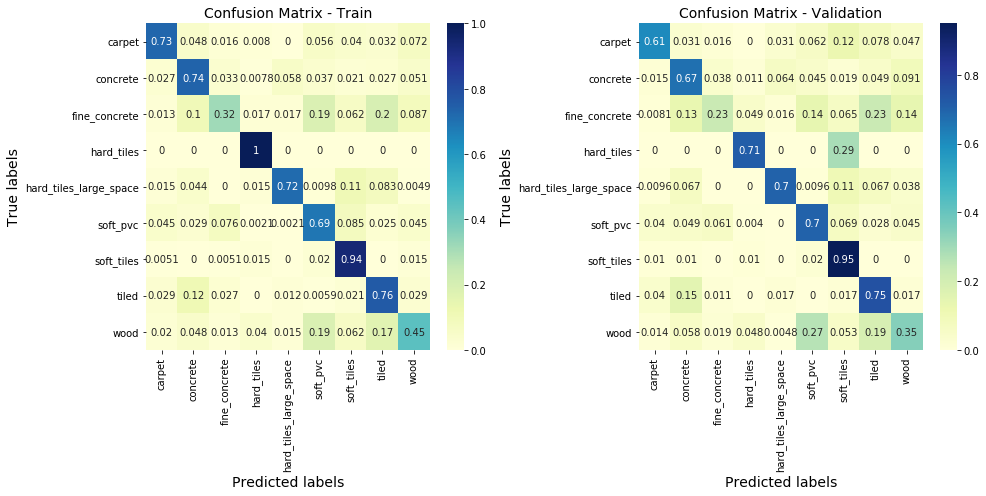

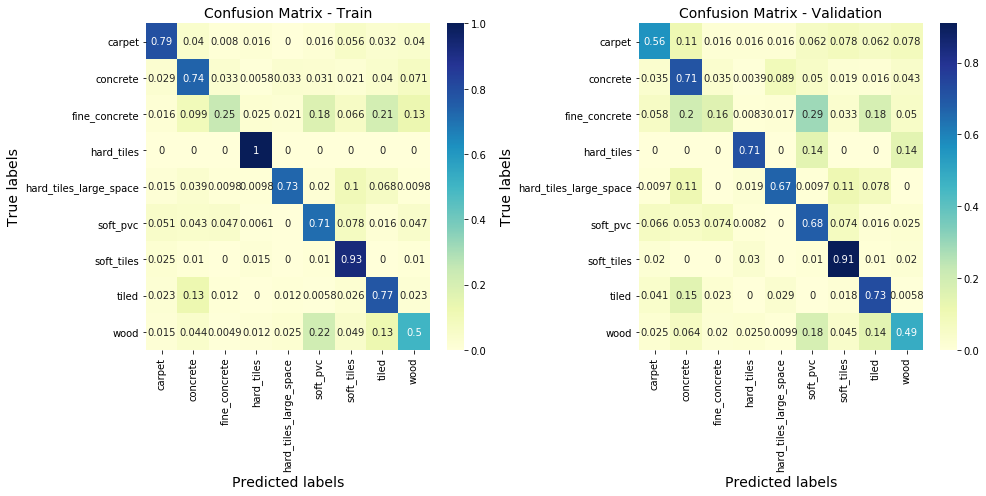

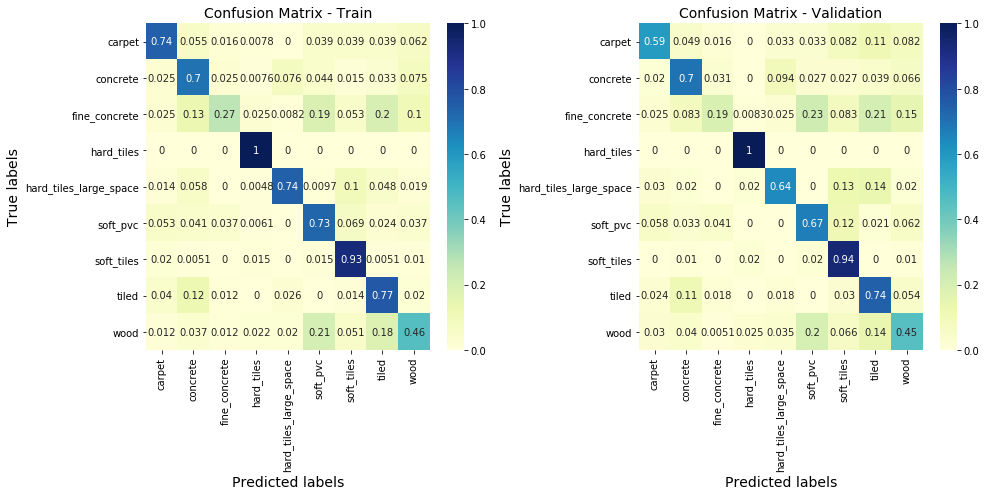

In [32]:
data_train = np.concatenate( (
    X_train_acc_X_fft_win, X_train_acc_Y_fft_win, X_train_acc_Z_fft_win, 
    X_train_ang_X_fft_win, X_train_ang_Y_fft_win, X_train_ang_Z_fft_win,
    X_train_ori_X_fft_win, X_train_ori_Y_fft_win, X_train_ori_Z_fft_win, X_train_ori_W_fft_win
    ), axis = 1)

data_train_red = data_train

y_train_red = y_train

train_acc = []
valid_acc = []

train_conf_mat = []
valid_conf_mat = []

from catboost import CatBoostClassifier

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'    

cbc_clf = CatBoostClassifier(classes_count = 9, loss_function = 'MultiClassOneVsAll', 
                             iterations = 400, depth = 3, l2_leaf_reg = 5.0, learning_rate = 0.03, 
                             model_size_reg = 0.5, boosting_type = 'Plain', random_strength = 1, rsm = 1)

from sklearn.model_selection import StratifiedKFold

split = StratifiedKFold(n_splits = 3, shuffle = True)

t0 = time()

for train_index, valid_index in split.split(data_train_red, y_train_red['group_id'].values):
        
    data_train_strat, y_train_strat = data_train_red[train_index], y_train_red['surface'].iloc[train_index].values
    data_valid_strat, y_valid_strat = data_train_red[valid_index], y_train_red['surface'].iloc[valid_index].values

    y_train_strat_asint = np.array([terrains_dict.get(y_train_strat[j]) for j in range(len(y_train_strat))])
    y_valid_strat_asint = np.array([terrains_dict.get(y_valid_strat[j]) for j in range(len(y_valid_strat))])

    from sklearn.utils.class_weight import compute_sample_weight

    sample_weight = compute_sample_weight(class_weight = 'balanced', y = y_train_strat_asint)
    
    cbc_clf.fit(data_train_strat, y_train_strat_asint, sample_weight = sample_weight, silent = True) 

    from sklearn.metrics import accuracy_score, confusion_matrix
        
    train_acc.append(accuracy_score(y_train_strat_asint, cbc_clf.predict(data_train_strat)))
    valid_acc.append(accuracy_score(y_valid_strat_asint, cbc_clf.predict(data_valid_strat)))
    
    train_conf_mat.append(confusion_matrix(y_train_strat_asint, cbc_clf.predict(data_train_strat)))
    valid_conf_mat.append(confusion_matrix(y_valid_strat_asint, cbc_clf.predict(data_valid_strat)))

t1 = time()

print("Time: {}".format(round(t1 - t0, 4)))

print("Train accuracy (scale):      {} \nAverage train accuracy: {}".format(train_acc, np.mean(train_acc)))
print("Validation accuracy (scale): {} \nAverage validation accuracy: {}".format(valid_acc, np.mean(valid_acc)))

for l in range(len(train_conf_mat)):
    plt.figure(figsize = (14,7))

    ax1 = plt.subplot(121)
    sns.heatmap(train_conf_mat[l]/np.sum(train_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax1, cmap="YlGnBu"); 
    ax1.set_xlabel('Predicted labels', fontsize = 14);
    ax1.set_ylabel('True labels', fontsize = 14);
    ax1.set_title('Confusion Matrix - Train', fontsize = 14);
    ax1.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax1.yaxis.set_ticklabels(terrains, rotation = 'horizontal');    

    ax2 = plt.subplot(122)
    sns.heatmap(valid_conf_mat[l]/np.sum(valid_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax2, cmap="YlGnBu"); 
    ax2.set_xlabel('Predicted labels', fontsize = 14);
    ax2.set_ylabel('True labels', fontsize = 14);
    ax2.set_title('Confusion Matrix - Validation', fontsize = 14);
    ax2.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax2.yaxis.set_ticklabels(terrains, rotation = 'horizontal');

    plt.tight_layout()
    plt.show()

Even better results can be obtained if we consider both time-domain and frequency-domain features for all channels:

Time: 115.1624
Train accuracy (scale):      [0.8130210400952759, 0.8068450039339103, 0.8030480656506448] 
Average train accuracy: 0.8076380365599437
Validation accuracy (scale): [0.7714949651432997, 0.751577287066246, 0.7561950439648282] 
Average validation accuracy: 0.759755765391458


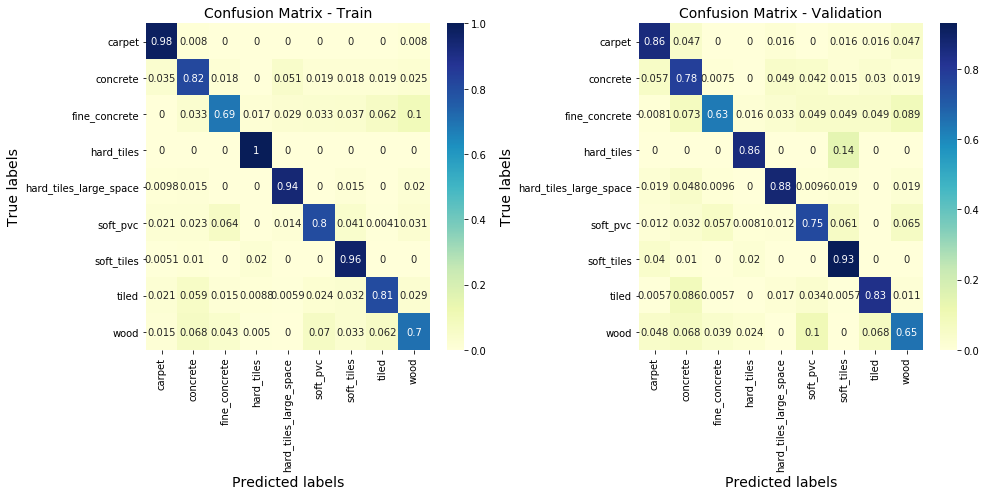

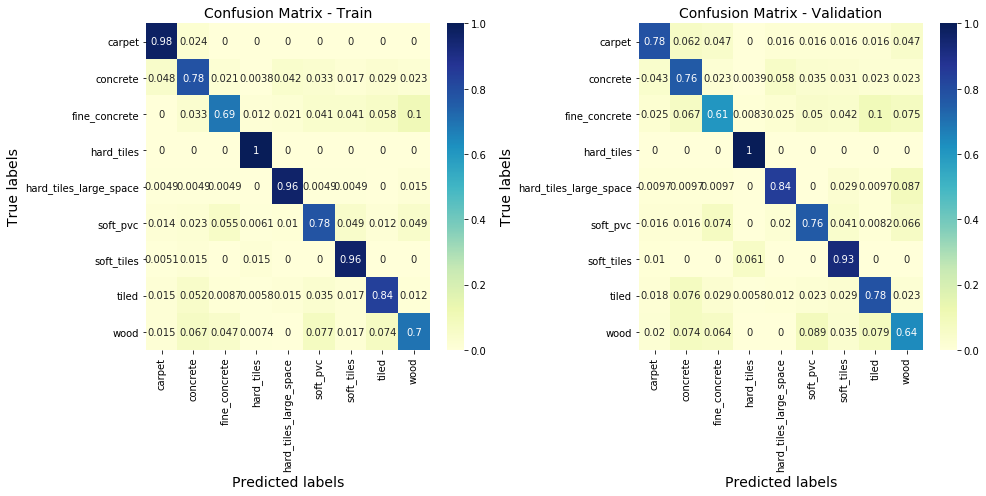

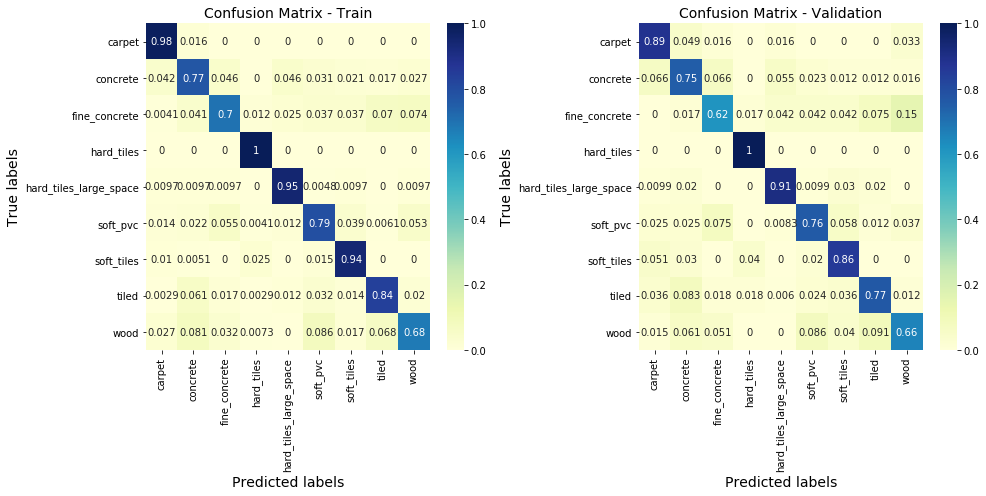

In [33]:
data_train = np.concatenate( (
    X_train_acc_X_fft_win, X_train_acc_Y_fft_win, X_train_acc_Z_fft_win, 
    X_train_ang_X_fft_win, X_train_ang_Y_fft_win, X_train_ang_Z_fft_win,
    X_train_ori_X_fft_win, X_train_ori_Y_fft_win, X_train_ori_Z_fft_win, X_train_ori_W_fft_win,
    X_train_acc_X_psd_win, X_train_acc_Y_psd_win, X_train_acc_Z_psd_win, 
    X_train_ang_X_psd_win, X_train_ang_Y_psd_win, X_train_ang_Z_psd_win,
    X_train_ori_X_psd_win, X_train_ori_Y_psd_win, X_train_ori_Z_psd_win, X_train_ori_W_psd_win,
    X_train_acc_X_feat, X_train_acc_Y_feat, X_train_acc_Z_feat, 
    X_train_ang_X_feat, X_train_ang_Y_feat, X_train_ang_Z_feat,
    X_train_ori_X_feat, X_train_ori_Y_feat, X_train_ori_Z_feat, X_train_ori_W_feat
    ), axis = 1)

data_train_red = data_train

y_train_red = y_train

train_acc = []
valid_acc = []

train_conf_mat = []
valid_conf_mat = []

from catboost import CatBoostClassifier

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'    

cbc_clf = CatBoostClassifier(classes_count = 9, loss_function = 'MultiClassOneVsAll', 
                             iterations = 400, depth = 3, l2_leaf_reg = 5.0, learning_rate = 0.055, 
                             model_size_reg = 0.5, boosting_type = 'Plain', random_strength = 1, rsm = 1)

from sklearn.model_selection import StratifiedKFold

split = StratifiedKFold(n_splits = 3, shuffle = True)

t0 = time()

for train_index, valid_index in split.split(data_train_red, y_train_red['group_id'].values):
        
    data_train_strat, y_train_strat = data_train_red[train_index], y_train_red['surface'].iloc[train_index].values
    data_valid_strat, y_valid_strat = data_train_red[valid_index], y_train_red['surface'].iloc[valid_index].values

    y_train_strat_asint = np.array([terrains_dict.get(y_train_strat[j]) for j in range(len(y_train_strat))])
    y_valid_strat_asint = np.array([terrains_dict.get(y_valid_strat[j]) for j in range(len(y_valid_strat))])

    from sklearn.utils.class_weight import compute_sample_weight

    sample_weight = compute_sample_weight(class_weight = 'balanced', y = y_train_strat_asint)
    
    cbc_clf.fit(data_train_strat, y_train_strat_asint, sample_weight = sample_weight, silent = True) 

    from sklearn.metrics import accuracy_score, confusion_matrix
        
    train_acc.append(accuracy_score(y_train_strat_asint, cbc_clf.predict(data_train_strat)))
    valid_acc.append(accuracy_score(y_valid_strat_asint, cbc_clf.predict(data_valid_strat)))
    
    train_conf_mat.append(confusion_matrix(y_train_strat_asint, cbc_clf.predict(data_train_strat)))
    valid_conf_mat.append(confusion_matrix(y_valid_strat_asint, cbc_clf.predict(data_valid_strat)))

t1 = time()

print("Time: {}".format(round(t1 - t0, 4)))

print("Train accuracy (scale):      {} \nAverage train accuracy: {}".format(train_acc, np.mean(train_acc)))
print("Validation accuracy (scale): {} \nAverage validation accuracy: {}".format(valid_acc, np.mean(valid_acc)))

for l in range(len(train_conf_mat)):
    plt.figure(figsize = (14,7))

    ax1 = plt.subplot(121)
    sns.heatmap(train_conf_mat[l]/np.sum(train_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax1, cmap="YlGnBu"); 
    ax1.set_xlabel('Predicted labels', fontsize = 14);
    ax1.set_ylabel('True labels', fontsize = 14);
    ax1.set_title('Confusion Matrix - Train', fontsize = 14);
    ax1.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax1.yaxis.set_ticklabels(terrains, rotation = 'horizontal');    

    ax2 = plt.subplot(122)
    sns.heatmap(valid_conf_mat[l]/np.sum(valid_conf_mat[l], axis = 1).reshape(-1,1), annot = True, 
                ax = ax2, cmap="YlGnBu"); 
    ax2.set_xlabel('Predicted labels', fontsize = 14);
    ax2.set_ylabel('True labels', fontsize = 14);
    ax2.set_title('Confusion Matrix - Validation', fontsize = 14);
    ax2.xaxis.set_ticklabels(terrains, rotation = 'vertical');        
    ax2.yaxis.set_ticklabels(terrains, rotation = 'horizontal');

    plt.tight_layout()
    plt.show()

Slightly better results can be obtained by adjusting hyperparameters and building soft voting ensemble classifiers, which is what we did for the final submission which got a public leaderboard of 0.73 (we can also only use not all features but just the most relevant ones as dictated by `.feature_importances_`). Let us also mention that it is not just the CatBoost classifier to improve its performance once the orientation channels are included, but all models we considered (although in many cases the improvement is less prominent).

***

## Conclusions

To conclude, this is a summary of our approach to the competition:

* We decided to use both time-domain and frequency-domain features as suggested by the literature we consulted;


* Although we would have prefered to use only linear acceleration and angular velocity channels, we decided to use information about all 10 channels, since different observations in the same group come from the same experiment and orientation channels are quite useful to determine whether two observations are so related or not;


* We used an ensemble of CatBoost classifiers, although other models may have had a better score on the public leaderboard.